# Modelling and Functional Characterization of the Pyridoxamine Kinase/Phosphomethylpyrimidine Kinase Domain Family
**Biological Data, A.Y. 2023/24 - Final Project**

**Authors**: Marco Uderzo, Tanner Graves, Claudio Palmeri


# Domain Model Definition

**UniProt query for SwissProt Entries with Pfam domain:**

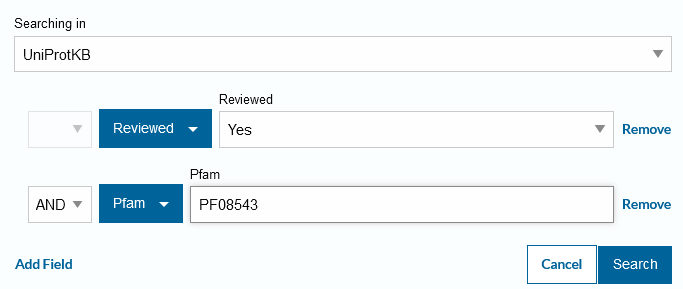

- Returns only 150 proteins
- If you use all of UniProt, number is over 60000

## Model Building / Refinement

Initial PSSM built on SwissProt pblast results  

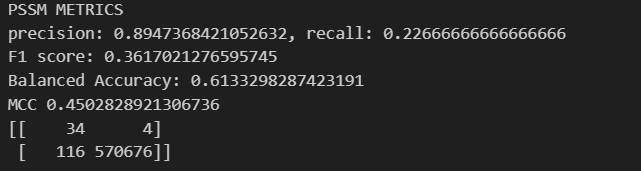  


Verification build  
Results from normal pblast website 
Used sprot  
53 results  
saved FASTA as BLASTWEB_sprot.fasta  
added representative query sequence to alignment in JalView  
Aligned from JalView with clustalw webservice  
Consulted pblast results to 
clustalw -INFILE=BLASTWEB_sprot.fasta -OUTFILE=pblast1.aln  

## Seed Test
downloaded the seed alignment from the PFAM entry

Steps taken : Observed signifiantly conserved central regions flanked by tails and heads of sequences that are significantly longer
No sequence terminates in the perserved region of the MSA to be used for the seed alignment  
For sequences that open notable gaps in the alignment we investigated their hit in the pBLAST results


In [1]:
!pip install PyQt5

You should consider upgrading via the 'C:\Users\marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install goatools
!pip install ete3

You should consider upgrading via the 'C:\Users\marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sb
from wordcloud import WordCloud
from goatools import obo_parser
from Bio import SeqIO
import json
import sys
from urllib.error import HTTPError
from urllib.request import urlopen
from math import sqrt
from scipy.stats import fisher_exact
from ete3 import Tree
from ete3.treeview.main import TreeStyle, NodeStyle

In [4]:
data_dir = 'data/'

In [5]:
# Search BLAST with Query sequence
# download results as FASTA
# GENERATE MSA (CLUSTALW)
# IN JALVIEW add query sequence in new row
# Realign MSA. Take part of MSA that is covered by query sequence.
# we can do this because we checked that query is representative of family
# Remove the query sequence and save as EditedMSA_noCull_sprot.fa


In [6]:
## 1: Generate Predictions
## Code:
## Done by submitting pssm to blast website
## MODEL: PSI-BLAST
# psiblast -db uniprot_sprot.fasta -in_msa EditedMSA_noCull_sprot.fa -out_ascii_pssm noCull_pssm.txt -out_pssm noCull.pssm
# PSSM uploaded to NCBI hosted PSI-blast, download resulting hittable as refinedPSSM_hits.csv
## DB - swisprot
# Col names from header in txt results
pssm_col_names = [
    'acc_query',
    'acc_subject',
    '%_identity',
    'alignment_length',
    'mismatches',
    'gap_opens',
    'q_start',
    'q_end',
    's_start',
    's_end',
    'evalue',
    'bit_score',
    '%positives'
]
# First PSSM build, return 38 hits (many false negatives)
#pssm_hits = pd.read_csv('PSSM-HitTable1.csv', names=pssm_col_names)
# Refined PSSM, returns 74 hits
# More than doubles the true positives (72)! still significant False negatives (78)
pssm_hits = pd.read_csv(data_dir + 'refinedPSSM_hits.csv', names=pssm_col_names)
pssm_hits['acc'] = pssm_hits['acc_subject'].str.split('.').str[0]
pred_pssm_df = pssm_hits[['acc','alignment_length','q_start','q_end','s_start','s_end']]
pred_pssm_df.sort_values(by='acc')

,acc,alignment_length,q_start,q_end,s_start,s_end
70,A0A0H2WZY4,150,362,508,145,287
38,A1ADT5,181,336,512,90,269
59,A3N2D3,166,337,495,77,241
48,A5UA83,187,337,514,77,262
51,A6VNE5,161,337,490,77,236
...,...,...,...,...,...,...
32,Q9USL6,272,257,508,4,274
47,Q9WZP7,245,268,508,2,204
24,Q9ZBL1,246,282,521,30,273
17,Q9ZBR6,242,282,522,27,263


In [7]:
# File is the text output of hmmsearch
# BASH:
# uses the first MSA
# hmmbuild finalTest.hmm finalMSA_edit.aln
# hmmsearch finalTest.hmm swissprot_ftp.fasta > hmm_HitRaw.txt

# contains a lot of information, but we only what the info from the second part, 
# which contains lists of alignments, and will need to be manually pasrsed.
with open(data_dir + 'hmm_HitRaw.txt') as f:
    hmmTXT = f.read()

In [8]:
pred_hmm_acc = []
pred_hmm_start = []
pred_hmm_stop = []
pred_hmm_ali_start = []
pred_hmm_ali_stop = []
pred_hmm_env_start = []
pred_hmm_env_stop = []
pred_hmm_E = []
hmmAlns = str.split(hmmTXT,'>>')[1:]
aln_header = ['score', 'bias', 'c-Evalue', 'i-Evalue', 'hmm_from', 'hmm_to', 'ali_from', 'ali_to', 'env_from', 'env_to', 'acc']
for i, aln in enumerate(hmmAlns):
    aln_lines = str.split(aln,'\n')
    pred_hmm_acc.append(str.split(aln_lines[0],'|')[1])
    aln_vals_raw = str.split(aln_lines[3])[2:]
    aln_vals = aln_vals_raw[0:6]+aln_vals_raw[7:9]+aln_vals_raw[10:12]+aln_vals_raw[13:14]
    pred_hmm_E.append(aln_vals[2])
    pred_hmm_start.append(aln_vals[4])
    pred_hmm_stop.append(aln_vals[5])
    pred_hmm_ali_start.append(aln_vals[6])
    pred_hmm_ali_stop.append(aln_vals[7])
    pred_hmm_env_start.append(aln_vals[8])
    pred_hmm_env_stop.append(aln_vals[9])
    if i==10:
        #DEBUG
        #print(aln_lines[0])
        tst = 10
        #print(aln_header[tst], aln_vals[tst])
pred_hmm_df = pd.DataFrame({
    'acc': pred_hmm_acc,
    'hmm_start': pred_hmm_start,
    'hmm_stop': pred_hmm_stop,
    'ali_start': pred_hmm_ali_start,
    'ali_stop': pred_hmm_ali_stop,
    'env_start': pred_hmm_env_start,
    'env_stop':pred_hmm_env_stop,
    'E_val':pred_hmm_E
    })
pred_hmm_df

,acc,hmm_start,hmm_stop,ali_start,ali_stop,env_start,env_stop,E_val
0,Q08975,13,529,1,535,1,535,6.1e-225
1,Q08224,13,529,1,535,1,535,5.2e-220
2,Q5M731,7,523,1,520,1,522,4.1e-217
3,O48881,7,525,1,523,1,523,8e-215
4,Q06490,2,528,12,555,11,556,5.7e-213
...,...,...,...,...,...,...,...,...
945,A9MKV9,164,267,130,229,123,256,0.016
946,A0PRY2,357,503,57,204,47,215,0.011
947,P33020,154,196,233,274,226,337,0.014
948,B8E2P6,234,258,444,468,424,475,0.022


In [9]:
#thresholding, entries sorted by E_VAL
pred_hmm_df = pred_hmm_df.head(150) 

In [10]:
#  downloaded from Uniprot with filters reviewed = True, PFAM = PF08543
# Get the ACCs of sequences actually in PFAM family
groundTruth_download_df = pd.read_csv(data_dir + 'sprot_PHAM_GroundTruth.tsv', sep='\t')
truth_pfam_acc = list(groundTruth_download_df['Entry'])
print(len(truth_pfam_acc))
truth_pfam_acc[0:10]

150


['O00764',
 'O35331',
 'O46560',
 'O48881',
 'P39610',
 'P40191',
 'P61422',
 'P76422',
 'P77150',
 'P82197']

FTP link in doc wrong, correct one is:
ftp://ftp.ebi.ac.uk/pub/databases/interpro/current/protein2ipr.dat.gz
19 Gigabytes! use API instead

In [11]:
# This cell can be run instead of the one below, to use info from previous run
# saves 3 min
# same as above but processed to have only needed fields
truth_pfam_df = pd.read_csv(data_dir + 'truth_pfam.csv')

In [12]:
# Code adaptapted from example on interpro API github
# https://github.com/ProteinsWebTeam/interpro7-api/blob/master/docs/examples/fetch-protein-matches.py
family = 'PF08543'
api_url = "https://www.ebi.ac.uk/interpro/api"

truth_pfam_numFragments = [] # sanity check
truth_pfam_start = []
truth_pfam_stop = []
truth_pfam_len = []
truth_pfam_score = []

# query for each uniprot accention indicated by interpro as having target family
for i, query in enumerate(truth_pfam_acc): 
    url = f"{api_url}/entry/all/protein/UniProt/{query}/"
    url += "?page_size=200&extra_fields=hierarchy,short_name"
    with urlopen(url) as res:
        data = json.loads(res.read().decode("utf-8"))
    for result in data['results']:
        if result['metadata']['accession'] == family:
            fragments = result['proteins'][0]['entry_protein_locations'][0]['fragments']
            numFragments = len(fragments)
            start = fragments[0]['start']
            stop = fragments[0]['end']
            f_len = stop - start
            score = result['proteins'][0]['entry_protein_locations'][0]['score']
            truth_pfam_numFragments.append(numFragments)
            truth_pfam_start.append(start)
            truth_pfam_stop.append(stop)
            truth_pfam_len.append(f_len)
            truth_pfam_score.append(score)
            #DEBUG
            #print(query, start, stop, f_len, numFragments, score)
            #print(result['proteins'][0]['entry_protein_locations'][0]['score'])
            #print(result['proteins'][0]['entry_protein_locations'][0]['fragments'])
truth_pfam_df = pd.DataFrame({
    'acc': truth_pfam_acc,
    'start': truth_pfam_start,
    'stop': truth_pfam_stop,
    'lenght': truth_pfam_len,
    'score': truth_pfam_score,
    'nFragments': truth_pfam_numFragments
})
truth_pfam_df

,acc,start,stop,lenght,score,nFragments
0,O00764,94,275,181,1.300000e-12,1
1,O35331,94,273,179,2.600000e-13,1
2,O46560,104,284,180,2.900000e-13,1
3,O48881,42,285,243,2.400000e-82,1
4,P39610,13,260,247,3.800000e-86,1
...,...,...,...,...,...,...
145,Q9HT57,78,263,185,1.400000e-08,1
146,Q9RYX0,100,270,170,2.200000e-09,1
147,Q9ZBL1,23,272,249,2.200000e-80,1
148,Q9ZBR6,20,262,242,1.700000e-86,1


In [13]:
truth_pfam_df.to_csv('truth_pfam.csv')

## Models Evaluation

In [14]:
print(len(pred_pssm_df))
pred_pssm_df.head()

74


,acc,alignment_length,q_start,q_end,s_start,s_end
0,Q6G7L7,266,272,537,11,276
1,P66915,266,272,537,11,276
2,Q6GEY2,266,272,537,11,276
3,P44697,247,282,525,21,266
4,P55882,252,275,523,13,262


In [15]:
print(len(truth_pfam_df))
truth_pfam_df.head()

150


,acc,start,stop,lenght,score,nFragments
0,O00764,94,275,181,1.300000e-12,1
1,O35331,94,273,179,2.600000e-13,1
2,O46560,104,284,180,2.900000e-13,1
3,O48881,42,285,243,2.400000e-82,1
4,P39610,13,260,247,3.800000e-86,1


### PSSM

In [16]:
# METRICS
pssm_eval_df = pd.merge(truth_pfam_df, pred_pssm_df, on='acc', how='outer')
tp_pssm_df = pssm_eval_df[pssm_eval_df['lenght'].notna() & pssm_eval_df['alignment_length'].notna()]
fp_pssm_df = pssm_eval_df[pssm_eval_df['lenght'].isna() & pssm_eval_df['alignment_length'].notna()]
fn_pssm_df = pssm_eval_df[pssm_eval_df['lenght'].notna() & pssm_eval_df['alignment_length'].isna()]
tp_pssm = len(tp_pssm_df)
fp_pssm = len(fp_pssm_df)
fn_pssm = len(fn_pssm_df)
len_sprot = 570830 # len of sprot_df (checked), used for calculating TN
tn_pssm = len_sprot - tp_pssm - fp_pssm - fn_pssm
# TN = (len(sprot) - len(positives)) - FN = N - FN
precision_pssm = tp_pssm / (tp_pssm + fp_pssm)
recall_pssm = tp_pssm / (tp_pssm + fn_pssm)
F1_pssm =  2*tp_pssm / (2*tp_pssm + fp_pssm + fn_pssm)
sensitivity_pssm = tp_pssm / (tp_pssm + fn_pssm)
specificity_pssm = tn_pssm / (tn_pssm + fp_pssm)
balAcc_pssm = 0.5 *((sensitivity_pssm) + (specificity_pssm))
mcc_pssm = (tp_pssm * tn_pssm - fp_pssm * fn_pssm) / sqrt((tp_pssm + fp_pssm) * (tp_pssm + fn_pssm) * (tn_pssm + fp_pssm) * (tn_pssm + fn_pssm))
#accuracy_pssm = (tp_pssm + tn_pssm) / len_sprot
print("PSSM METRICS")
print(f"precision: {precision_pssm}, recall: {recall_pssm}")
print(f"F1 score: {F1_pssm}")
print(f"Balanced Accuracy: {balAcc_pssm}")
print(f"MCC {mcc_pssm}")
confusion_pssm = np.array([[tp_pssm,fp_pssm],[fn_pssm,tn_pssm]])
print(confusion_pssm)
pssm_eval_df


PSSM METRICS
precision: 0.972972972972973, recall: 0.48
F1 score: 0.6428571428571429
Balanced Accuracy: 0.7399982477044929
MCC 0.683343266905964
[[    72      2]
 [    78 570678]]


,acc,start,stop,lenght,score,nFragments,alignment_length,q_start,q_end,s_start,s_end
0,O00764,94.0,275.0,181.0,1.300000e-12,1.0,102.0,339.0,437.0,88.0,185.0
1,O35331,94.0,273.0,179.0,2.600000e-13,1.0,154.0,348.0,484.0,94.0,243.0
2,O46560,104.0,284.0,180.0,2.900000e-13,1.0,113.0,346.0,453.0,102.0,210.0
3,O48881,42.0,285.0,243.0,2.400000e-82,1.0,270.0,261.0,527.0,28.0,297.0
4,P39610,13.0,260.0,247.0,3.800000e-86,1.0,256.0,272.0,524.0,10.0,264.0
...,...,...,...,...,...,...,...,...,...,...,...
147,Q9ZBL1,23.0,272.0,249.0,2.200000e-80,1.0,246.0,282.0,521.0,30.0,273.0
148,Q9ZBR6,20.0,262.0,242.0,1.700000e-86,1.0,242.0,282.0,522.0,27.0,263.0
149,Q9ZL00,14.0,261.0,247.0,2.500000e-84,1.0,248.0,282.0,527.0,21.0,267.0
150,O01824,NaN,NaN,NaN,NaN,NaN,162.0,340.0,486.0,110.0,253.0


**Protein Level performance Evaluation (PSSM)**

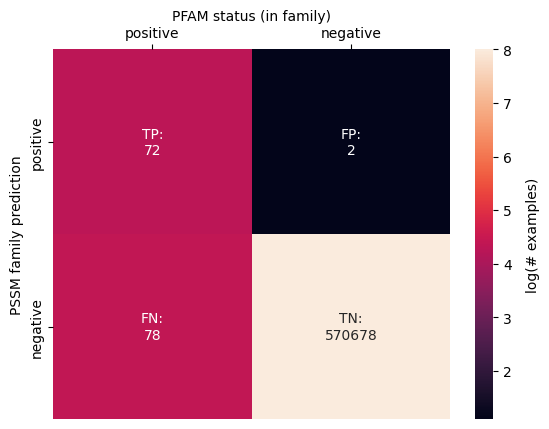

In [17]:
confusion_pssm_df = pd.DataFrame(confusion_pssm, columns=['positive', 'negative'], index=['positive','negative'])
conf_pssm_text = [[f'TP:\n{tp_pssm}', f'FP:\n{fp_pssm}'],[f'FN:\n{fn_pssm}', f'TN:\n{tn_pssm}']]
ax = sb.heatmap(np.log1p(confusion_pssm_df),annot=conf_pssm_text, fmt='', vmax=8)
ax.set_xlabel('PFAM status (in family)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_ylabel('PSSM family prediction')
cbar = ax.collections[0].colorbar
cbar.set_label('log(# examples)', labelpad=10)

**Residue Level Performance Evaluation (PSSM)**

In [18]:
pssm_eval_df.head()

,acc,start,stop,lenght,score,nFragments,alignment_length,q_start,q_end,s_start,s_end
0,O00764,94.0,275.0,181.0,1.300000e-12,1.0,102.0,339.0,437.0,88.0,185.0
1,O35331,94.0,273.0,179.0,2.600000e-13,1.0,154.0,348.0,484.0,94.0,243.0
2,O46560,104.0,284.0,180.0,2.900000e-13,1.0,113.0,346.0,453.0,102.0,210.0
3,O48881,42.0,285.0,243.0,2.400000e-82,1.0,270.0,261.0,527.0,28.0,297.0
4,P39610,13.0,260.0,247.0,3.800000e-86,1.0,256.0,272.0,524.0,10.0,264.0


In [19]:
max(pssm_eval_df['stop'])

498.0

In [20]:
def pfam_pred_overlap(a, b, c, d, op='both'):
    """
    Calculate the bounds of the overlap between two ranges (a, b) and (c, d), or the bounds
    of ranges that are exclusively in one interval but not the other, based on the operation specified.
    
    Parameters:
    - a, b: Endpoints of the first range, with a <= b.
    - c, d: Endpoints of the second range, with c <= d.
    - op: Operation specifying which bounds to calculate ('left', 'right', or 'both').
    
    Returns:
    The bounds of the overlap or exclusive ranges based on the specified operation.
    """
    
    if op == 'both':
        # Original behavior: Calculate the overlap bounds
        overlap_start = max(a, c)
        overlap_end = min(b, d)
        
        # Check if there is no overlap
        if overlap_start >= overlap_end:
            return None, None  # No overlap
        return overlap_start, overlap_end
    
    elif op == 'left':
        # Bounds of range in (a, b) but not in (c, d)
        if b <= c or a >= d:  # No overlap
            return a, b  # Entire (a, b) range
        else:
            left_start = a
            left_end = min(b, c)  # Adjusted to exclude overlap with (c, d)
            if left_start >= left_end:  # Check if there's meaningful range
                return None, None  # No exclusive range in (a, b)
            return left_start, left_end
    
    elif op == 'right':
        # Bounds of range in (c, d) but not in (a, b)
        if d <= a or c >= b:  # No overlap
            return c, d  # Entire (c, d) range
        else:
            right_start = max(d, a)  # Adjusted to exclude overlap with (a, b)
            right_end = d
            if right_start >= right_end:  # Check if there's meaningful range
                return None, None  # No exclusive range in (c, d)
            return right_start, right_end

# Example usage:
print(pfam_pred_overlap(1, 5, 4, 8, 'both'))  # Overlap
print(pfam_pred_overlap(1, 5, 4, 8, 'left'))  # Exclusive to (a, b)
print(pfam_pred_overlap(1, 5, 4, 8, 'right'))  # Exclusive to (c, d)


(4, 5)
(1, 4)
(None, None)


In [21]:
pfam_pred_overlap(1,4,10,20)

(None, None)

In [22]:
max(max(pssm_eval_df['stop']), max(pssm_eval_df['s_end']))

499.0

In [23]:
# Get a dict of the len of each protein in sprot
# used for calculating the number of True Negative AA classifications
# Downloaded from uniprot with reviewed = True, and add col for sequences and PFAM
sprot_len_dict = pd.read_csv(data_dir + 'info_sprot_seq.tsv',sep='\t')[['Entry','Length']].set_index('Entry').to_dict()['Length']

In [24]:
pssm_eval_df.head()

,acc,start,stop,lenght,score,nFragments,alignment_length,q_start,q_end,s_start,s_end
0,O00764,94.0,275.0,181.0,1.300000e-12,1.0,102.0,339.0,437.0,88.0,185.0
1,O35331,94.0,273.0,179.0,2.600000e-13,1.0,154.0,348.0,484.0,94.0,243.0
2,O46560,104.0,284.0,180.0,2.900000e-13,1.0,113.0,346.0,453.0,102.0,210.0
3,O48881,42.0,285.0,243.0,2.400000e-82,1.0,270.0,261.0,527.0,28.0,297.0
4,P39610,13.0,260.0,247.0,3.800000e-86,1.0,256.0,272.0,524.0,10.0,264.0


In [25]:
#max_res = int(max(max(pssm_eval_df['stop']), max(pssm_eval_df['s_end'])))
img = []
processed_accs = []
for i, r in pssm_eval_df.iterrows():
    acc_uni = r['acc']
    processed_accs.append(acc_uni)
    try:
        pfam_start = int(r['start'])
        pfam_stop = int(r['stop'])
    except: 
        pfam_start, pfam_stop = None, None
    try:
        subject_start = int(r['s_start'])
        subject_stop = int(r['s_end'])
    except:
        subject_start, subject_stop = None, None
    img_row = np.zeros((sprot_len_dict[acc_uni]),dtype='int')
    # 0:TN (incomplete! count residues that are not in family or FPs)
    # 1:TP
    # 2:FN
    # 3:FP
    if subject_start == None: # pred start is nan -> FN
        # No PSSM prediction
        # all of PFAM range labled as FN
        img_row[pfam_start:pfam_stop] = 2
    elif pfam_start == None:
        # There is a PSSM pred, but no pfam hit -> FP
        img_row[subject_start:subject_stop] = 3
    else:
        TP_start, TP_stop = pfam_pred_overlap(pfam_start, pfam_stop, subject_start, subject_stop, op='both')
        FP_start, FP_stop = pfam_pred_overlap(pfam_start, pfam_stop, subject_start, subject_stop, op='right')
        FN_start, FN_stop = pfam_pred_overlap(pfam_start, pfam_stop, subject_start, subject_stop, op='left')
        if TP_start != None:
            img_row[TP_start:TP_stop] = 1
        if FP_start != None:
            img_row[FP_start:FP_stop] = 3
        if FN_start != None:
            img_row[FN_start:FN_stop] = 2
    img.append(list(img_row))
#img = np.array(img)
#cmap = ListedColormap(['w', 'g', 'r', 'y'])
#plt.imshow(img, cmap=cmap, interpolation='nearest')
#plt.title("Residue-Wise PSSM Predictions")
#plt.xlim(10,300)
        #print(TP_start,TP_stop)
    #for j in range(max_res): # I can think of better ways than brute force, but this is good enough


In [26]:
# Iterate over the sequece and position of img
# count TP, TN, FP, FN
TN_total_pssm = 0 #0
TP_total_pssm = 0 #1
FN_total_pssm = 0 #2
FP_total_pssm = 0 #3
for seq in img:
    for pos in seq:
        if pos == 0: # TN
            TN_total_pssm += 1
        elif pos == 1: # TP
            TP_total_pssm += 1
        elif pos == 2: # FN
            FN_total_pssm += 1
        elif pos == 3: # FP
            FP_total_pssm += 1
# Go through the TN PROTEINS and add their lenght to TN POSITION count
unprocessed_accs = [acc for acc in list(sprot_len_dict.keys()) if acc not in processed_accs]
for acc in unprocessed_accs: 
    TN_total_pssm += sprot_len_dict[acc]
print([[TP_total_pssm, FP_total_pssm],[FN_total_pssm, TN_total_pssm]])


[[14134, 285], [14624, 206504117]]


In [27]:
precision_pssm_pos = TP_total_pssm / (TP_total_pssm + FP_total_pssm)
recall_pssm_pos = TP_total_pssm / (TP_total_pssm + FN_total_pssm)
F1_pssm_pos =  2*TP_total_pssm / (2*TP_total_pssm + FP_total_pssm + FN_total_pssm)
sensitivity_pssm_pos = TP_total_pssm / (TP_total_pssm + FN_total_pssm)
specificity_pssm_pos = TN_total_pssm / (TN_total_pssm + FP_total_pssm)
balAcc_pssm_pos = 0.5 *((sensitivity_pssm_pos) + (specificity_pssm_pos))
mcc_pssm_pos = (TP_total_pssm * TN_total_pssm - FP_total_pssm * FN_total_pssm) / sqrt((TP_total_pssm + FP_total_pssm) * (TP_total_pssm + FN_total_pssm) * (TN_total_pssm + FP_total_pssm) * (TN_total_pssm + FN_total_pssm))
#accuracy_pssm = (TP_total_pssm + TN_total_pssm) / len_sprot
print("pssm POSITION METRICS")
print(f"precision: {precision_pssm_pos}, recall: {recall_pssm_pos}")
print(f"F1 score: {F1_pssm_pos}")
print(f"Balanced Accuracy: {balAcc_pssm_pos}")
print(f"MCC: {mcc_pssm_pos}")
confusion_pssm_pos = np.array([[TP_total_pssm,FP_total_pssm],[FN_total_pssm,TN_total_pssm]])
confusion_pssm_pos

pssm POSITION METRICS
precision: 0.9802344129273874, recall: 0.4914806314764587
F1 score: 0.6547004192046691
Balanced Accuracy: 0.7457396256803002
MCC: 0.6940677724882568


array([[    14134,       285],
       [    14624, 206504117]])

### HMM

In [28]:
pred_hmm_df.head()

,acc,hmm_start,hmm_stop,ali_start,ali_stop,env_start,env_stop,E_val
0,Q08975,13,529,1,535,1,535,6.1e-225
1,Q08224,13,529,1,535,1,535,5.2e-220
2,Q5M731,7,523,1,520,1,522,4.1e-217
3,O48881,7,525,1,523,1,523,8e-215
4,Q06490,2,528,12,555,11,556,5.7e-213


In [29]:
#HMM METRICS
hmm_eval_df = pd.merge(truth_pfam_df, pred_hmm_df, on='acc', how='outer')
tp_hmm_df = hmm_eval_df[hmm_eval_df['lenght'].notna() & hmm_eval_df['ali_start'].notna()]
fp_hmm_df = hmm_eval_df[hmm_eval_df['lenght'].isna() & hmm_eval_df['ali_start'].notna()]
fn_hmm_df = hmm_eval_df[hmm_eval_df['lenght'].notna() & hmm_eval_df['ali_start'].isna()]
tp_hmm = len(tp_hmm_df)
fp_hmm = len(fp_hmm_df)
fn_hmm = len(fn_hmm_df)
tn_hmm = len_sprot - tp_hmm - fp_hmm - fn_hmm
# Calculate metrics
# this is a mess, consider using sklearn (requires bulding df for all of sprot)
precision_hmm = tp_hmm / (tp_hmm + fp_hmm)
recall_hmm = tp_hmm / (tp_hmm + fn_hmm)
F1_hmm =  2*tp_hmm / (2*tp_hmm + fp_hmm + fn_hmm)
sensitivity_hmm = tp_hmm / (tp_hmm + fn_hmm)
specificity_hmm = tn_hmm / (tn_hmm + fp_hmm)
balAcc_hmm = 0.5 *((sensitivity_hmm) + (specificity_hmm))
mcc_hmm = (tp_hmm * tn_hmm - fp_hmm * fn_hmm) / sqrt((tp_hmm + fp_hmm) * (tp_hmm + fn_hmm) * (tn_hmm + fp_hmm) * (tn_hmm + fn_hmm))
#accuracy_hmm = (tp_hmm + tn_hmm) / len_sprot
print("HMM METRICS")
print(f"precision: {precision_hmm}, recall: {recall_hmm}")
print(f"F1 score: {F1_hmm}")
print(f"Balanced Accuracy: {balAcc_hmm}")
print(f"MCC: {mcc_hmm}")
confusion_hmm = np.array([[tp_hmm,fp_hmm],[fn_hmm,tn_hmm]])
confusion_hmm

HMM METRICS
precision: 0.9933333333333333, recall: 0.9933333333333333
F1 score: 0.9933333333333333
Balanced Accuracy: 0.9966657905189131
MCC: 0.9933315810378263


array([[   149,      1],
       [     1, 570679]])

**Protein Level performance Evaluation (HMM)**

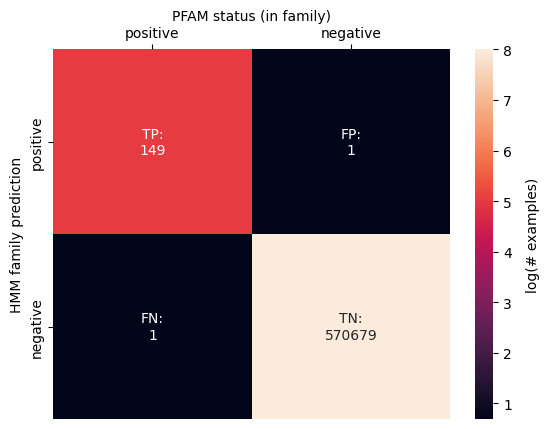

In [30]:
confusion_hmm_df = pd.DataFrame(confusion_hmm, columns=['positive', 'negative'], index=['positive','negative'])
conf_pssm_text = [[f'TP:\n{tp_hmm}', f'FP:\n{fp_hmm}'],[f'FN:\n{fn_hmm}', f'TN:\n{tn_hmm}']]
ax = sb.heatmap(np.log1p(confusion_hmm_df),annot=conf_pssm_text, fmt='', vmax=8)
ax.set_xlabel('PFAM status (in family)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_ylabel('HMM family prediction')
cbar = ax.collections[0].colorbar
cbar.set_label('log(# examples)', labelpad=10)

**Residue Level Performance Evaluation (HMM)**

In [31]:
#max_res = int(max(max(hmm_eval_df['stop']), max(hmm_eval_df['s_end'])))
img_hmm = []
processed_accs = []
for i, r in hmm_eval_df.iterrows():
    acc_uni = r['acc']
    processed_accs.append(acc_uni)
    try:
        pfam_start = int(r['start'])
        pfam_stop = int(r['stop'])
    except: 
        pfam_start, pfam_stop = None, None
    try:
        subject_start = int(r['hmm_start'])
        subject_stop = int(r['hmm_stop'])
    except:
        subject_start, subject_stop = None, None
    img_hmm_row = np.zeros((sprot_len_dict[acc_uni]),dtype='int')
    # 0:TN (incomplete! count residues that are not in family or FPs)
    # 1:TP
    # 2:FN
    # 3:FP
    if subject_start == None: # pred start is nan -> FN
        # No hmm prediction
        # all of PFAM range labled as FN
        img_hmm_row[pfam_start:pfam_stop] = 2
    elif pfam_start == None:
        # There is a hmm pred, but no pfam hit -> FP
        img_hmm_row[subject_start:subject_stop] = 3
    else:
        TP_start, TP_stop = pfam_pred_overlap(pfam_start, pfam_stop, subject_start, subject_stop, op='both')
        FP_start, FP_stop = pfam_pred_overlap(pfam_start, pfam_stop, subject_start, subject_stop, op='right')
        FN_start, FN_stop = pfam_pred_overlap(pfam_start, pfam_stop, subject_start, subject_stop, op='left')
        if TP_start != None:
            img_hmm_row[TP_start:TP_stop] = 1
        if FP_start != None:
            img_hmm_row[FP_start:FP_stop] = 3
        if FN_start != None:
            img_hmm_row[FN_start:FN_stop] = 2
    img_hmm.append(list(img_hmm_row))
#img_hmm = np.array(img_hmm)
#cmap = ListedColormap(['w', 'g', 'r', 'y'])
#plt.imshow(img_hmm, cmap=cmap, interpolation='nearest')
#plt.title("Residue-Wise hmm Predictions")
#plt.xlim(10,300)
        #print(TP_start,TP_stop)
    #for j in range(max_res): # I can think of better ways than brute force, but this is good enough

In [32]:
# Iterate over the sequece and position of img_hmm
# count TP, TN, FP, FN
TN_total_hmm = 0 #0
TP_total_hmm = 0 #1
FN_total_hmm = 0 #2
FP_total_hmm = 0 #3
for seq in img_hmm:
    for pos in seq:
        if pos == 0: # TN
            TN_total_hmm += 1
        elif pos == 1: # TP
            TP_total_hmm += 1
        elif pos == 2: # FN
            FN_total_hmm += 1
        elif pos == 3: # FP
            FP_total_hmm += 1
# Go through the TN PROTEINS and add their lenght to TN POSITION count
unprocessed_accs = [acc for acc in list(sprot_len_dict.keys()) if acc not in processed_accs]
for acc in unprocessed_accs: 
    TN_total_hmm += sprot_len_dict[acc]
print([[TP_total_hmm, FP_total_hmm],[FN_total_hmm, TN_total_hmm]])


[[28504, 295], [749, 206503612]]


In [33]:
precision_hmm_pos = TP_total_hmm / (TP_total_hmm + FP_total_hmm)
recall_hmm_pos = TP_total_hmm / (TP_total_hmm + FN_total_hmm)
F1_hmm_pos =  2*TP_total_hmm / (2*TP_total_hmm + FP_total_hmm + FN_total_hmm)
sensitivity_hmm_pos = TP_total_hmm / (TP_total_hmm + FN_total_hmm)
specificity_hmm_pos = TN_total_hmm / (TN_total_hmm + FP_total_hmm)
balAcc_hmm_pos = 0.5 *((sensitivity_hmm_pos) + (specificity_hmm_pos))
mcc_hmm_pos = (TP_total_hmm * TN_total_hmm - FP_total_hmm * FN_total_hmm) / sqrt((TP_total_hmm + FP_total_hmm) * (TP_total_hmm + FN_total_hmm) * (TN_total_hmm + FP_total_hmm) * (TN_total_hmm + FN_total_hmm))
#accuracy_hmm = (TP_total_hmm + TN_total_hmm) / len_sprot
print("HMM POSITION METRICS")
print(f"precision: {precision_hmm_pos}, recall: {recall_hmm_pos}")
print(f"F1 score: {F1_hmm_pos}")
print(f"Balanced Accuracy: {balAcc_hmm_pos}")
print(f"MCC: {mcc_hmm_pos}")
confusion_hmm_pos = np.array([[TP_total_hmm,FP_total_hmm],[FN_total_hmm,TN_total_hmm]])
confusion_hmm_pos

HMM POSITION METRICS
precision: 0.9897565887704434, recall: 0.9743957884661403
F1 score: 0.9820161234755047
Balanced Accuracy: 0.98719717996087
MCC: 0.9820436363135745


array([[    28504,       295],
       [      749, 206503612]])

## Model Comparison Plot (protein & position)

In [34]:
def counts_to_lables(counts):
    names = ['TP\n', 'FP\n', 'FN\n', 'TN\n']
    lables = []
    for i in range(4):
        lables.append(names[i] + str(counts[i]))
    return [[lables[0], lables[1]],[lables[2], lables[3]]]

In [35]:

print('HMM')
print(confusion_hmm)
confusion_hmm_df = pd.DataFrame(confusion_hmm, columns=['positive', 'negative'], index=['positive','negative'])
confusion_hmm_txt = counts_to_lables(confusion_hmm.flatten())
#print(lables+conf_pssm_text)

print('HMM POS')
print(confusion_hmm_pos)
confusion_hmm_pos_df = pd.DataFrame(confusion_hmm_pos, columns=['positive', 'negative'], index=['positive','negative'])
confusion_hmm_pos_txt = counts_to_lables(confusion_hmm_pos.flatten())
print('PSSM')
print(confusion_pssm)
confusion_pssm_df = pd.DataFrame(confusion_pssm, columns=['positive', 'negative'], index=['positive','negative'])
confusion_pssm_txt = counts_to_lables(confusion_pssm.flatten())
print('PSSM POS')
print(confusion_pssm_pos)
confusion_pssm_pos_df = pd.DataFrame(confusion_pssm_pos, columns=['positive', 'negative'], index=['positive','negative'])
confusion_pssm_pos_txt = counts_to_lables(confusion_pssm_pos.flatten())

HMM
[[   149      1]
 [     1 570679]]
HMM POS
[[    28504       295]
 [      749 206503612]]
PSSM
[[    72      2]
 [    78 570678]]
PSSM POS
[[    14134       285]
 [    14624 206504117]]


[['TP\n72', 'FP\n2'], ['FN\n78', 'TN\n570678']]
[['TP\n149', 'FP\n1'], ['FN\n1', 'TN\n570679']]


[['TP\n14134', 'FP\n285'], ['FN\n14624', 'TN\n206504117']]
[['TP\n28504', 'FP\n295'], ['FN\n749', 'TN\n206503612']]


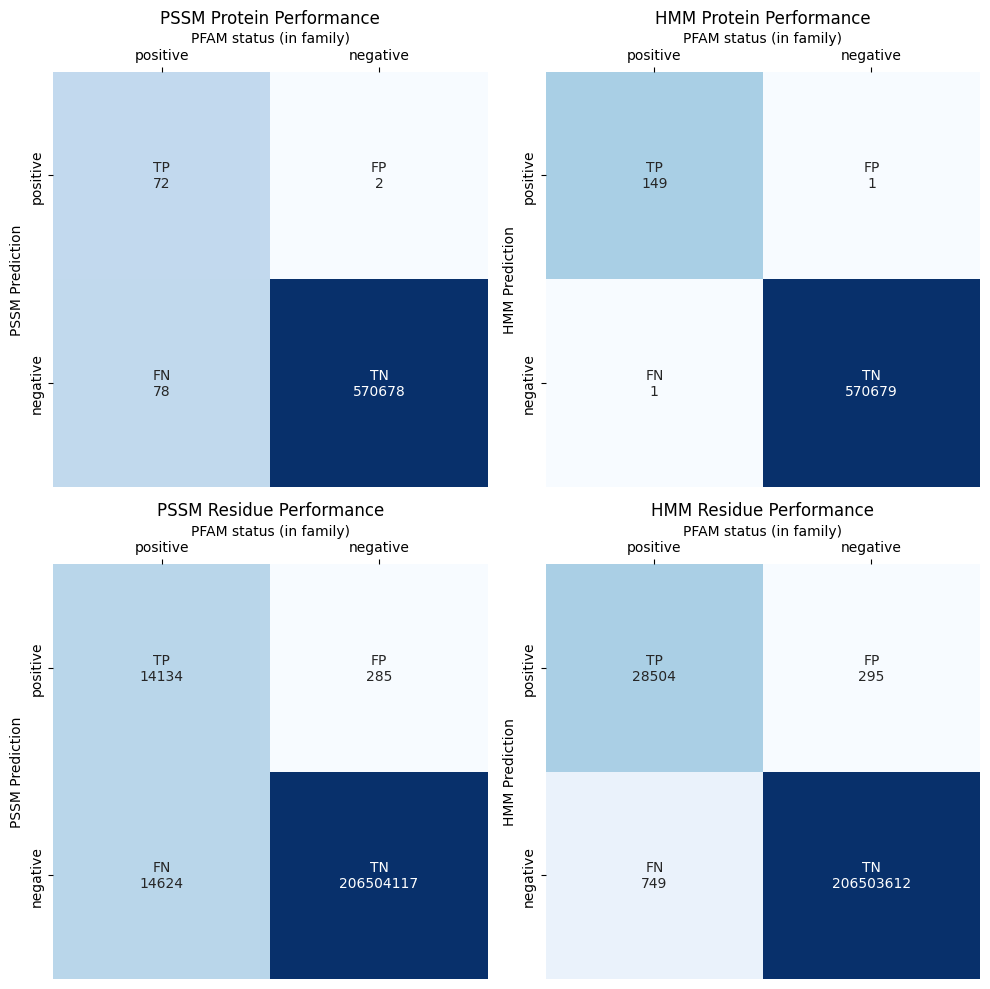

In [36]:
# Assuming confusion_hmm_df_list, titles, texts, and y_labels are provided as lists with 4 elements each
# For demonstration, placeholders are created. Please replace these with your actual data and parameters
confusion_hmm_df_list = [confusion_pssm_df, confusion_hmm_df, confusion_pssm_pos_df, confusion_hmm_pos_df]  # Your provided DataFrames
titles = ['PSSM Protein Performance', 'HMM Protein Performance', 'PSSM Residue Performance', 'HMM Residue Performance']  # Titles for each subplot
texts = [confusion_pssm_txt, confusion_hmm_txt, confusion_pssm_pos_txt, confusion_hmm_pos_txt]  # Text annotations for each subplot
y_labels = ['PSSM Prediction', 'HMM Prediction', 'PSSM Prediction', 'HMM Prediction']  # Y labels for each subplot

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Creates a 2x2 grid of subplots
axs = axs.flatten()  # Flatten the 2x2 grid to easily iterate

for i, ax in enumerate(axs):
    # Log transform and plot heatmap
    print(texts[i])
    sb.heatmap(np.log1p(confusion_hmm_df_list[i]), annot=np.array(texts[i]), fmt='',cmap='Blues', ax=ax, cbar=False)#,  # Add colorbar to only one plot
               #cbar_kws=None)#{'label': 'log(# examples)' if i == 0 else None})  # Add colorbar label to only one plot
    
    # Set the individual subplot titles, labels, etc.
    ax.set_title(titles[i])
    ax.set_xlabel('PFAM status (in family)')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(y_labels[i])

    # Since colorbar is linked to the first plot only, adjust accordingly if needed
    #if i == 0:  # Adjust colorbar for the first subplot
    #    cbar = ax.collections[0].colorbar
    #    cbar.set_label('log(# examples)', labelpad=10)

plt.tight_layout()
plt.show()


# Domain Family Characterization

## SwissProt loading

In [37]:
query_accs = list(pred_hmm_df['acc'])
#for q in query_accs:
#    print(q)

In [38]:
import requests
def uniprot_api_fetch_file(url, filename):
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        # Define the local filename to save the content
        filename = "familyInfo_sprot.tsv"
        
        # Open a file in write-binary mode and write the content
        with open(filename, "wb") as file:
            file.write(response.content)
        
        print(f"File downloaded successfully and saved as {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")


In [39]:
# IDs of sequences predicted by HMM model as being in family
model_family_accs = list(pred_hmm_df['acc'])
model_family_accs

['Q08975',
 'Q08224',
 'Q5M731',
 'O48881',
 'Q06490',
 'O94266',
 'Q2QWK9',
 'Q8NQH1',
 'Q8FTH8',
 'P61422',
 'P44697',
 'Q6GEY2',
 'Q6G7L7',
 'Q8NVH3',
 'O31620',
 'P66915',
 'P99124',
 'P55882',
 'P76422',
 'P56904',
 'Q9ZBR6',
 'P66914',
 'P9WG76',
 'P9WG77',
 'Q9ZBL1',
 'Q5HI96',
 'Q8CTQ7',
 'Q5HRG7',
 'P39610',
 'O25515',
 'Q9ZL00',
 'O85786',
 'O67772',
 'Q9WZP7',
 'A8A2R4',
 'B1IX53',
 'B1XA89',
 'C4ZVU9',
 'P40191',
 'B7N609',
 'A7ZPL9',
 'B6I4Z5',
 'B7M6S8',
 'B7UGB9',
 'Q3YZC3',
 'B7NPV5',
 'A1ADT5',
 'B7MHS2',
 'B7MY71',
 'Q0TF48',
 'Q1R8V2',
 'Q8FFB5',
 'B2TX08',
 'B7LL66',
 'B5YZW5',
 'Q8XBL0',
 'Q32DD5',
 'B1LML3',
 'B7LCG3',
 'Q83K78',
 'Q8D4Q2',
 'Q7MGA4',
 'A7N5Q6',
 'Q87FP6',
 'Q6LP62',
 'Q66A50',
 'Q1C792',
 'Q1CIM6',
 'Q7CIR8',
 'O94265',
 'O83153',
 'Q7N3W7',
 'O01824',
 'Q51892',
 'Q57PI7',
 'Q8ZPM8',
 'Q1LFU5',
 'Q5PIK8',
 'Q8X649',
 'Q0THJ1',
 'Q1RBF9',
 'Q8FH89',
 'P77150',
 'Q320Z3',
 'Q5PNC8',
 'P40192',
 'Q57LS3',
 'Q83KY1',
 'Q6D5V1',
 'Q9RYX0',
 'Q32FD7',

In [40]:
# dowinloading sprot from API takes awhile, so load from prevous run
# uncomment uniprot_api_fetch_file lines to refetch

# has all of sprot with additional feilds pretaining to GO and taxonomy
#fam_url = "https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Cxref_pfam%2Clineage%2Clineage_ids%2Cgo_id%2Cgo_f%2Cgo%2Cgo_c%2Cgo_p&format=tsv&query=%28%28xref%3Apfam-PF08543%29+AND+%28reviewed%3Atrue%29%29"
# These are our true positives
fam_info_df = pd.read_csv(data_dir + 'familyInfo_sprot_seq.tsv', sep='\t')

#mdl_info_df = pd.read_csv('familyInfo_sprot_seq.tsv', sep='\t')
#uniprot_api_fetch_file(fam_url, 'familyInfo_sprot.tsv')
sprot_url = "https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Cxref_pfam%2Clineage%2Clineage_ids%2Cgo_id%2Cgo_f%2Cgo%2Cgo_c%2Cgo_p&format=tsv&query=%28%28reviewed%3Atrue%29%29"
#uniprot_api_fetch_file(sprot_url, 'info_sprot.tsv') #Takes like 10 min
sprot_info_df = pd.read_csv(data_dir + 'info_sprot_seq_prosite.tsv', sep='\t')

mdl_info_df = sprot_info_df[sprot_info_df['Entry'].isin(model_family_accs)]
mdl_info_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Pfam,Taxonomic lineage,Taxonomic lineage (Ids),Gene Ontology IDs,Gene Ontology (molecular function),Gene Ontology (GO),Gene Ontology (cellular component),Gene Ontology (biological process),Sequence,PROSITE
4204,O00764,reviewed,PDXK_HUMAN,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK C21orf124 C21orf97 PKH PNK PRED79,Homo sapiens (Human),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0000287; GO:0005524; GO:0005576; GO:0005634...,ATP binding [GO:0005524]; lithium ion binding ...,cytosol [GO:0005829]; extracellular exosome [G...,cytosol [GO:0005829]; extracellular exosome [G...,phosphorylation [GO:0016310]; pyridoxal 5'-pho...,MEEECRVLSIQSHVIRGYVGNRAATFPLQVLGFEIDAVNSVQFSNH...,NaN
5601,O35331,reviewed,PDXK_RAT,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,Pdxk Pkh,Rattus norvegicus (Rat),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009410...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],negative regulation of apoptotic process [GO:0...,MEGECRVLSIQSHVVRGYVGNRAAMFPLQVLGFEVDAVNSVQFSNH...,NaN
6209,O46560,reviewed,PDXK_PIG,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK PKH,Sus scrofa (Pig),322,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009443...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...,MQAGSWVVGGGDSDSRVLSIQSHVVRGYVGNRAATFPLQVLGFEVD...,NaN
6247,O48881,reviewed,TPS1_BRANA,Thiamine biosynthetic bifunctional enzyme BTH1...,BTH1,Brassica napus (Rape),523,PF08543;PF02581;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (...",GO:0004789; GO:0005524; GO:0008902; GO:0008972...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,chloroplast [GO:0009507]; ATP binding [GO:0005...,chloroplast [GO:0009507],phosphorylation [GO:0016310]; thiamine biosynt...,MQSLGGIRSWPATWRTTTASMTTTTTESVRKVAQVLTVAGSDSGAG...,NaN
19833,P39610,reviewed,PDXK_BACSU,Pyridoxine kinase (EC 2.7.1.35) (PN/PL/PM kina...,pdxK ywdB BSU38020 ipa-52r,Bacillus subtilis (strain 168),271,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0005524; GO:0005829; GO:0008478; GO:0008902...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; thiamine biosynt...,MSMHKALTIAGSDSSGGAGIQADLKTFQEKNVYGMTALTVIVAMDP...,NaN


## Taxonomy

In [41]:
tax_lineage_df = mdl_info_df[['Entry', 'Taxonomic lineage', 'Taxonomic lineage (Ids)']]
tax_lineage_df = tax_lineage_df.rename(columns={
    'Entry': 'acc',
    'Taxonomic lineage (Ids)': 'tax_id',
    'Taxonomic lineage': 'lineage'
})
tax_lineage_df

,acc,lineage,tax_id
4204,O00764,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (..."
5601,O35331,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (..."
6209,O46560,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (..."
6247,O48881,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (..."
19833,P39610,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."
...,...,...,...
295912,Q9HT57,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1224 (phyl..."
300498,Q9RYX0,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."
303956,Q9ZBL1,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."
303960,Q9ZBR6,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."


In [42]:
def extract_lin_rank(s):
    # Compile the regex pattern
    pattern = re.compile(r'^(.*?)\s*\((.*?)\)$')
    
    # Search the string using the pattern
    match = pattern.search(s.strip())
    
    if match:
        # Extract the matched groups, trimming any leading/trailing whitespace
        leading_text = match.group(1).strip()
        parenthetical_text = match.group(2).strip()
        return leading_text, parenthetical_text
    else:
        # Return None or some default value if no match is found
        return None
extract_lin_rank('131567 (no rank)')

('131567', 'no rank')

In [43]:
# uniprot reports taxonomy info using varying levels. For consistency we will take taxa info only at these levels
important_tax_levels = ['superkingdom','kingdom','phylum','class','order','family','genus','species']
# collect all the taxa sequences of examples as lists of decending order
lin_paths = []
rank_paths = []
id_paths = []
species_ids = []
species_ranks = []
for i, r in tax_lineage_df.iterrows():
    lin_seq = []
    rank_seq = []
    id_seq = []
    for j, lin_term in enumerate(r['lineage'].split(',')):
        name, rank = extract_lin_rank(lin_term)
        if rank in important_tax_levels:#!= 'no rank':
            lin_seq.append(name)
            rank_seq.append(rank)
    for j, lin_term in enumerate(r['tax_id'].split(',')):
        id, rank = extract_lin_rank(lin_term)
        if rank in important_tax_levels:#!= 'no rank':
            id_seq.append(id)
    if id not in species_ids:
        species_ids.append(id)
        species_ranks.append(rank)
    lin_paths.append(lin_seq)
    rank_paths.append(rank_seq)
    id_paths.append(id_seq)

In [44]:
ids = {}
edges = [] # not used
lineage_list = []
rank_list = []
id_list = []
count_dict = {} # this is mainly what we want 
name_dict = {} 
for i, r in tax_lineage_df.iterrows():
    #print(r['tax_id'])
    names = str.split(r['lineage'], ',')
    levels = str.split(r['tax_id'], ',')
    for j, level in enumerate(levels):
        id = str.split(level)[0]
        name = names[j]
        if j > 0:
            last_id = str.split(levels[j-1])[0]
            if f"{last_id},{id}" not in edges:
                edges.append(f"{last_id},{id}")
        rank  = str.split(level)[1]
        if id not in ids.keys():
            ids[id] = (name, rank,j, 1)
            count_dict[id] = 1
            name_dict[id] = extract_lin_rank(name)[0]
        else:
            #if j != ids[id][1]:
                #print(id,j,ids[id][3])
            ids[id] = (name, rank,j, ids[id][3]+1)
            count_dict[id] += 1

In [45]:
from collections import defaultdict
# first try key is id, values are children
# to be reimplemented

def add_lineage_to_tree(tree, lineage):
    for i in range(len(lineage)):
        node = lineage[i]
        if node not in tree:
            tree[node] = {}
        tree = tree[node]

def build_tree(lineages):
    tree = {}
    for lineage in lineages:
        add_lineage_to_tree(tree, lineage)
    return tree

tree_data = build_tree(id_paths)


In [46]:
def add_lineage_to_tree(tree, lineage, names, counts):
    """
    Adds a lineage to the tree with additional node attributes.

    Parameters:
    - tree: The current tree (dict).
    - lineage: A list representing the lineage (path in the tree).
    - names: A dictionary mapping node IDs to their names.
    - counts: A dictionary mapping node IDs to their counts.
    """
    for node_id in lineage:
        if node_id not in tree:
            tree[node_id] = {
                'id': node_id,
                'name': names.get(node_id, ""),
                'count': counts.get(node_id, 0),
                'children': {}
            }
        tree = tree[node_id]['children']

def build_tree(lineages, names, counts):
    """
    Builds a tree from a list of lineages with node attributes.

    Parameters:
    - lineages: A list of lineages, where each lineage is a list of node IDs.
    - names: A dictionary mapping node IDs to their names.
    - counts: A dictionary mapping node IDs to their counts.

    Returns:
    - A tree represented as a nested dictionary with node attributes.
    """
    tree = {}
    for lineage in lineages:
        add_lineage_to_tree(tree, lineage, names, counts)
    return tree


In [47]:
enriched_tree_data = build_tree(id_paths, name_dict, count_dict)
#enriched_tree_data

In [48]:
def to_newick(node, include_count=False):
    """
    Converts a tree node with attributes to a Newick string.
    
    Parameters:
    - node: The current node in the tree.
    - include_count: Boolean indicating whether to include the 'count' attribute in the node label.
    
    Returns:
    - A Newick-formatted string representation of the tree.
    """
    # Check if 'children' key exists and is not empty
    if 'children' in node and node['children']:  
        children_str = ','.join([to_newick(child, include_count) for child in node['children'].values()])
        node_str = f"({children_str})"
    else:
        # Leaf node or no children
        node_str = ''
    
    # Include node name and optionally count if it's not the root
    if node.get('name'):
        node_label = node['name']
        if include_count and 'count' in node:
            node_label += f"({node['count']})"
        node_str += node_label
    
    return node_str

# Ensure the function call matches your data structure
# Assuming `enriched_tree
to_newick(enriched_tree_data)

''

In [49]:
def dict_to_newick(tree, root_name=""):
    """
    Recursively converts a nested dictionary tree to a Newick string.
    
    Parameters:
    - tree: The nested dictionary representing the tree.
    - root_name: The name of the current root node (optional).
    
    Returns:
    - A Newick string representing the tree.
    """
    items = []
    for name, subtree in tree.items():
        if subtree:  # If the current node has children
            # Recursively process the subtree
            newick_subtree = dict_to_newick(subtree, name)
            items.append(newick_subtree)
        else:
            # Leaf node
            items.append(name)
    # Join all items with commas, enclose in parentheses, and add root name
    joined_items = ",".join(items)
    if root_name:
        return f"({joined_items}){root_name}"
    else:
        return f"({joined_items});"

In [50]:
def enrich_tree_with_features(tree, name_dict, count_dict):
    for node in tree.traverse():
        # Assuming node.name contains the ID
        node_id = node.name
        #print(node.name)
        if node_id in name_dict:
            node.name = name_dict[node_id]
        # Add 'name' feature if ID exists in name_dict
        if node_id in name_dict:
            node.add_feature("tax_id", node_id)
        
        # Add 'count' feature if ID exists in count_dict
        if node_id in count_dict:
            node.add_feature("count", count_dict[node_id])
            

# Call the function to enrich the tree
#enrich_tree_with_features(tree, name_dict, count_dict)


In [51]:
## OPENS TREE IN INTERACTIVE VIEWER 

newick_str = dict_to_newick(tree_data)
print(newick_str)  # Optional: Print to verify the Newick string format

# Attempt to load the tree with ETE3

try:
    t = Tree(newick_str, format=1)
    enrich_tree_with_features(t,name_dict, count_dict)
    ts = TreeStyle()
    for node in t.traverse():
        ns = NodeStyle()
       # print(node.children)
        try:
            ns["size"] = count_dict[node.tax_id]
            ns["vt_line_width"] = 5  # Vertical line thickness
            ns["hz_line_width"] = 5  # Horizontal line thickness
        except:
            continue
        node.set_style(ns)
    ts.show_leaf_name = True
    ts.mode = 'c'
    ts.arc_start = -90
    ts.arc_span = 180
    t.show(tree_style=ts)
except Exception as e:
    print(f"Error loading tree: {e}")

(((((((9605)9604)9443,((10114,10088)10066)9989,((9822)9821,(9935,9903)9895)91561)40674)7711,((((7090)7089)7088)50557)6656,((((6237)6243)6236)119089)6231)33208,(((((3705,3701)3700)3699,(((4530)4527)4479)38820)3398)35493)33090,((((((4932)4930)4893)4892)4891,((((4896)4895)4894)34346)147554)4890)4751,((((5782)2058185)2058949)142796)2605435)2759,((((((1423)1386)186817,((1280,1282)1279)90964)1385)91061)1239,(((((562,564)561,(28901)590,(621,622,624)620)543,((632,633)629)1903411,(583,(2218628)29487)1903414,((29471)122277)1903410)91347,(((715,67854)713,(727)724,(731)214906,(157673)697331,(747)745)712)135625,(((303,287,294,312306,29438,380021,317,251701)286)135621)72274,(((680,672,670)662,(668)511678,(74109)657)641)135623)1236,((((520,519,518,521)517)506,((148447,36873)1822464,(2978683,57975,28450,13373)32008,(119219)106589)119060)80840)28216,((((382)28105)82115)356,(((364410)364409)433)204441)28211)1224,(((((35554)28231)213422)3031668)3031651)200940,(((((152794,1718,1717)1716)1653,((1773,1769)1

In [52]:
def add_path(tree, path):
    for node in path:
        tree = tree.setdefault(node, {})
        
tree_root_manual = {}
for taxonomy in id_paths:
    add_path(tree_root_manual, taxonomy)

In [53]:
ids_trans = pd.DataFrame([{'key': key, 'rank_name': val[0], 'rank': val[2], 'abundance': val[3]} for key, val in ids.items()])
ids_trans

,key,rank_name,rank,abundance
0,131567,cellular organisms (no rank),0,150
1,2759,Eukaryota (superkingdom),1,22
2,33154,Opisthokonta (no rank),2,17
3,33208,Metazoa (kingdom),3,8
4,6072,Eumetazoa (no rank),4,8
...,...,...,...,...
341,85011,Kitasatosporales (order),5,1
342,2062,Streptomycetaceae (family),6,1
343,1883,Streptomyces (genus),7,1
344,1477431,Streptomyces albidoflavus group (no rank),8,1


## Functional Enrichment (GO annotation)

In [54]:
GO_mdl_df = mdl_info_df[['Entry', 'Gene Ontology (molecular function)', 'Gene Ontology (cellular component)', 'Gene Ontology (biological process)']]
GO_mdl_df = GO_mdl_df.rename(columns={
    'Entry':'acc', 
    'Gene Ontology (molecular function)': 'GO_mf_raw',
    'Gene Ontology (cellular component)': 'GO_cc_raw',
    'Gene Ontology (biological process)': 'GO_bp_raw'
    })
GO_mdl_df.head()


,acc,GO_mf_raw,GO_cc_raw,GO_bp_raw
4204,O00764,ATP binding [GO:0005524]; lithium ion binding ...,cytosol [GO:0005829]; extracellular exosome [G...,phosphorylation [GO:0016310]; pyridoxal 5'-pho...
5601,O35331,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829],negative regulation of apoptotic process [GO:0...
6209,O46560,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...
6247,O48881,ATP binding [GO:0005524]; hydroxymethylpyrimid...,chloroplast [GO:0009507],phosphorylation [GO:0016310]; thiamine biosynt...
19833,P39610,ATP binding [GO:0005524]; hydroxymethylpyrimid...,cytosol [GO:0005829],phosphorylation [GO:0016310]; thiamine biosynt...


In [55]:
GO_sprot_df = sprot_info_df[['Entry', 'Gene Ontology (molecular function)', 'Gene Ontology (cellular component)', 'Gene Ontology (biological process)']]
GO_sprot_df = GO_sprot_df.rename(columns={
    'Entry':'acc', 
    'Gene Ontology (molecular function)': 'GO_mf_raw',
    'Gene Ontology (cellular component)': 'GO_cc_raw',
    'Gene Ontology (biological process)': 'GO_bp_raw'
    })
print(len(GO_sprot_df))
GO_sprot_df.head()


570830


,acc,GO_mf_raw,GO_cc_raw,GO_bp_raw
0,A0A009IHW8,NAD(P)+ nucleosidase activity [GO:0050135]; NA...,NaN,NAD catabolic process [GO:0019677]; signal tra...
1,A0A023I7E1,"glucan endo-1,3-beta-D-glucosidase activity [G...",extracellular region [GO:0005576],cell wall organization [GO:0071555]; polysacch...
2,A0A024B7W1,"4 iron, 4 sulfur cluster binding [GO:0051539];...",centrosome [GO:0005813]; extracellular region ...,clathrin-dependent endocytosis of virus by hos...
3,A0A024SC78,cutinase activity [GO:0050525],extracellular region [GO:0005576],NaN
4,A0A024SH76,"cellulose 1,4-beta-cellobiosidase activity [GO...",extracellular region [GO:0005576],cellulose catabolic process [GO:0030245]


In [56]:
# seperate the name from ID from how uniprot reports GO terms
def parse_go_annotation(annotation):
    # Define a regular expression pattern to match the name and GO ID
    pattern = r'^(.*?)\s*\[GO:(\d+)\]$'
    match = re.match(pattern, annotation)
    if match:
        # Extract name and GO ID from the matched groups
        name = match.group(1)
        go_id = 'GO:' + match.group(2)  # Prepend 'GO:' to the ID
        return name, go_id
    else:
        return None, None

In [57]:
parse_go_annotation('metal ion binding [GO:0046872]')

('metal ion binding', 'GO:0046872')

In [58]:
dict_tuple_header = ['name', 'domain', 'count']# for reference
# Get the counts of each term in a population of sequences (Family model / all of sprot)
def build_GO_enrichment(df):
    GO_dict = {}
    Go_dict_alt = {}
    for i, r in df.iterrows():
        try: 
            mf_list = str.split(r['GO_mf_raw'],';')
        except: # no GO terms for domain
            mf_list = []
        try:
            cc_list = str.split(r['GO_cc_raw'],';')
        except:
            cc_list = []
        try:
            bp_list = str.split(r['GO_bp_raw'],';')
        except:
            bp_list = []
        # Parse molecular function terms
        for j, term in enumerate(mf_list):
            term_name, term_id = parse_go_annotation(term)
            if term_id not in GO_dict.keys():
                GO_dict[term_id] = (term_name, 'mf', 1)
            else:
                GO_dict[term_id] = (GO_dict[term_id][0],'mf', GO_dict[term_id][2]+1)
        # Parse cellular component terms
        for j, term in enumerate(cc_list):
            term_name, term_id = parse_go_annotation(term)
            if term_id not in GO_dict.keys():
                GO_dict[term_id] = (term_name, 'cc', 1)
            else:
                GO_dict[term_id] = (GO_dict[term_id][0],'cc', GO_dict[term_id][2]+1)
        # Parse biological process terms
        for j, term in enumerate(bp_list):
            term_name, term_id = parse_go_annotation(term)
            if term_id not in GO_dict.keys():
                GO_dict[term_id] = (term_name, 'bp', 1)
            else:
                GO_dict[term_id] = (GO_dict[term_id][0],'bp', GO_dict[term_id][2]+1)
    out_df  = pd.DataFrame([{'term_id': key, 'term_name': val[0], 'domain': val[1], 'count': val[2]} for key, val in GO_dict.items()])
    return out_df

In [59]:
mdl_enrichment_df = build_GO_enrichment(GO_mdl_df)
#mdl_enrichment_df.to_csv('mdl_enrichment.tsv',sep='\t')

In [60]:
sprot_enrichment_df = build_GO_enrichment(GO_sprot_df)
#sprot_enrichment_df.to_csv('sprot_enrichment.tsv',sep='\t')

In [61]:
print('mdl', len(mdl_enrichment_df))
print('sprot', len(sprot_enrichment_df))

mdl 56
sprot 29000


In [62]:
nprot_sprot = 570830 # The number of proteins in sprot used for normalization

In [63]:
nprot_mdl = len(mdl_info_df)
nprot_sprot = len(sprot_info_df)
sprot_enrichment_df['prob_term'] = sprot_enrichment_df['count'] / nprot_sprot
mdl_enrichment_df['prob_term'] = mdl_enrichment_df['count'] / nprot_mdl
plot_enrichment_df = sprot_enrichment_df[['term_id','prob_term']].sort_values(by='prob_term',ascending=False).reset_index(drop=True)
plot_enrichment_df = pd.merge(plot_enrichment_df,mdl_enrichment_df[['term_id','prob_term']], how='outer', on='term_id')
plot_enrichment_df

,term_id,prob_term_x,prob_term_y
0,GO:0005737,0.285831,0.013333
1,GO:0005524,0.155668,0.993333
2,GO:0005886,0.118167,NaN
3,GO:0046872,0.103062,0.126667
4,GO:0006412,0.090060,NaN
...,...,...,...
28995,GO:0075294,0.000002,NaN
28996,GO:0035842,0.000002,NaN
28997,GO:0097184,0.000002,NaN
28998,GO:0036213,0.000002,NaN


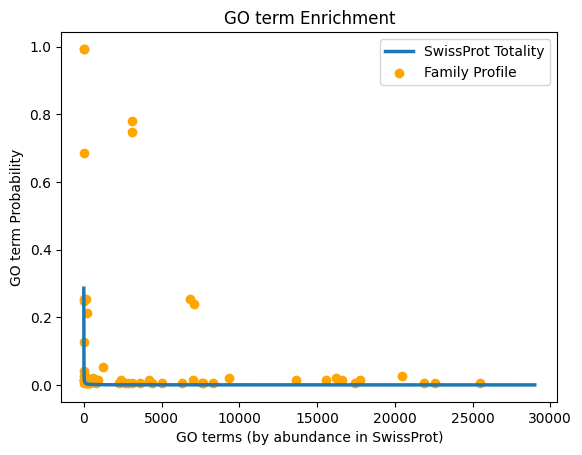

In [64]:
plt.plot(plot_enrichment_df['prob_term_x'], linewidth=2.5, label='SwissProt Totality')
mdl_idx = plot_enrichment_df[plot_enrichment_df['prob_term_y'].notna()].index
mdl_probs = plot_enrichment_df['prob_term_y'].iloc[mdl_idx]
plt.scatter(mdl_idx,mdl_probs, c='orange', label='Family Profile')
plt.title("GO term Enrichment")
plt.ylabel("GO term Probability")
plt.xlabel("GO terms (by abundance in SwissProt)")
plt.legend()
plt.show()

In order to visualize what GO terms are characteristic of our family, we can plot the enrichment (probability) of observing a go term over both our model family and the totality of SwissProt. Selecting the terms with the highest odds, or the ratio of probability that the term is observed in the family and all of Swiss prot will give us an idea of which terms are most charactaristic.

In [65]:
#exact_df defined below. In case you want to run this, run the cell below this before, uncomment the line and run.
#exact_df[['term_id','term_name_x','odds']].sort_values(by='odds', ascending=False)

### Fisher Exact Test

In [66]:
exact_df = pd.merge(sprot_enrichment_df,mdl_enrichment_df, on='term_id')
# see if I need to subtract the Y(MDL) counts from the X(nonMDL) counts
#exact_df['count_x'] = exact_df['count_x'] - exact_df['count_y'] # I THINK I need this, might not effect calculation because the sets are so different in size
exact_df['countB_x'] = nprot_sprot - exact_df['count_x'] # x for sprot not in family
exact_df['countB_y'] = len(mdl_info_df) - exact_df['count_y']
exact_df['odds'] = exact_df['prob_term_y'] / exact_df['prob_term_x'] #P(term in fam) / P(term in sprot)
print(len(exact_df))
exact_df

56


,term_id,term_name_x,domain_x,count_x,prob_term_x,term_name_y,domain_y,count_y,prob_term_y,countB_x,countB_y,odds
0,GO:0005576,extracellular region,cc,28262,0.049510,extracellular region,cc,2,0.013333,542568,148,0.269304
1,GO:0005524,ATP binding,mf,88860,0.155668,ATP binding,mf,149,0.993333,481970,1,6.381099
2,GO:0046872,metal ion binding,mf,58831,0.103062,metal ion binding,mf,19,0.126667,511999,131,1.229031
3,GO:0005737,cytoplasm,cc,163161,0.285831,cytoplasm,cc,2,0.013333,407669,148,0.046648
4,GO:0005634,nucleus,cc,38822,0.068010,nucleus,cc,6,0.040000,532008,144,0.588151
5,GO:0016310,phosphorylation,bp,17798,0.031179,phosphorylation,bp,149,0.993333,553032,1,31.858887
6,GO:0042803,protein homodimerization activity,mf,4999,0.008757,protein homodimerization activity,mf,4,0.026667,565831,146,3.045036
7,GO:0009507,chloroplast,cc,8282,0.014509,chloroplast,cc,4,0.026667,562548,146,1.837978
8,GO:0005829,cytosol,cc,29035,0.050865,cytosol,cc,38,0.253333,541795,112,4.980550
9,GO:0000287,magnesium ion binding,mf,27281,0.047792,magnesium ion binding,mf,103,0.686667,543549,47,14.367873


In [67]:
def calculate_pvalue(vals):
    table = [[vals['count_y'], vals['count_x']], [vals['countB_y'], vals['countB_x']]]
    _, p_value = fisher_exact(table,alternative='two-sided')
    return p_value
def calculate_pvalue_r(vals): # I feel like there should be a better way of doing this
    table = [[vals['count_y'], vals['count_x']], [vals['countB_y'], vals['countB_x']]]
    _, p_value = fisher_exact(table,alternative='greater')
    return p_value
exact_df['p'] = exact_df.apply(calculate_pvalue, axis=1)
exact_df['r'] = exact_df.apply(calculate_pvalue_r, axis=1)

In [68]:
exact_df

,term_id,term_name_x,domain_x,count_x,prob_term_x,term_name_y,domain_y,count_y,prob_term_y,countB_x,countB_y,odds,p,r
0,GO:0005576,extracellular region,cc,28262,0.049510,extracellular region,cc,2,0.013333,542568,148,0.269304,3.656043e-02,9.956600e-01
1,GO:0005524,ATP binding,mf,88860,0.155668,ATP binding,mf,149,0.993333,481970,1,6.381099,6.121219e-119,6.121219e-119
2,GO:0046872,metal ion binding,mf,58831,0.103062,metal ion binding,mf,19,0.126667,511999,131,1.229031,3.456764e-01,2.035727e-01
3,GO:0005737,cytoplasm,cc,163161,0.285831,cytoplasm,cc,2,0.013333,407669,148,0.046648,4.612852e-19,1.000000e+00
4,GO:0005634,nucleus,cc,38822,0.068010,nucleus,cc,6,0.040000,532008,144,0.588151,1.962929e-01,9.462004e-01
5,GO:0016310,phosphorylation,bp,17798,0.031179,phosphorylation,bp,149,0.993333,553032,1,31.858887,1.026916e-222,1.026916e-222
6,GO:0042803,protein homodimerization activity,mf,4999,0.008757,protein homodimerization activity,mf,4,0.026667,565831,146,3.045036,4.376105e-02,4.376105e-02
7,GO:0009507,chloroplast,cc,8282,0.014509,chloroplast,cc,4,0.026667,562548,146,1.837978,1.748990e-01,1.748990e-01
8,GO:0005829,cytosol,cc,29035,0.050865,cytosol,cc,38,0.253333,541795,112,4.980550,1.339938e-16,1.339938e-16
9,GO:0000287,magnesium ion binding,mf,27281,0.047792,magnesium ion binding,mf,103,0.686667,543549,47,14.367873,2.568458e-98,2.568458e-98


The p-value for the fisher test is extreamly close to 0 for terms with high odds, indicating that they are indeed chararistic of our family. However, as a consequence of how sparse GO labels are for a sequence compared to the abundance of our limited amout of terms (56) present in our family.

### Word Cloud

In [69]:
wc_dict = (mdl_enrichment_df.set_index('term_name')['prob_term']*10000).astype('int64').to_dict()

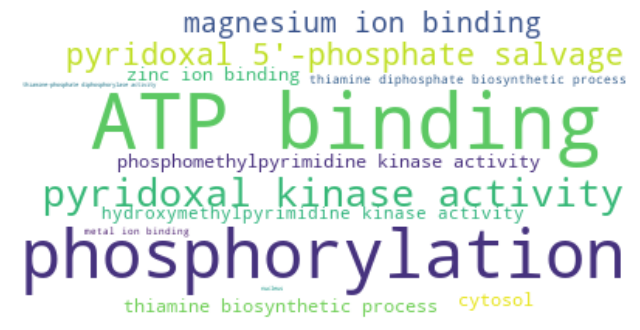

In [70]:
# EVERYTHING - ALL TERMS
# Perhaps not that useful
# Should probually use the following WCs seperated by domain
wc_dict = (mdl_enrichment_df.set_index('term_name')['prob_term']*10000).astype('int64').to_dict()
wc = WordCloud(background_color='white').generate_from_frequencies(wc_dict)
tst = {'A':7, 'Bee':5, 'what':1}
#wc = WordCloud(background_color='white').generate_from_frequencies(tst)
plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
#plt.title('All GO Terms')
plt.show()

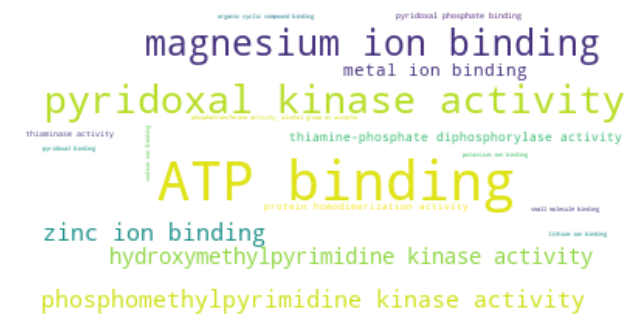

In [71]:
# MOLECULAR FUNCTION
wc_dict = (mdl_enrichment_df[mdl_enrichment_df['domain']=='mf'].set_index('term_name')['prob_term']*10000).astype('int64').to_dict()
wc = WordCloud(background_color='white').generate_from_frequencies(wc_dict)
plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

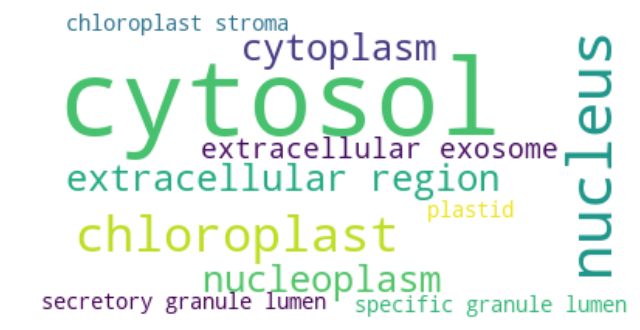

In [72]:
# CELLULAR COMPONENT
wc_dict = (mdl_enrichment_df[mdl_enrichment_df['domain']=='cc'].set_index('term_name')['prob_term']*10000).astype('int64').to_dict()
wc = WordCloud(background_color='white').generate_from_frequencies(wc_dict)
plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

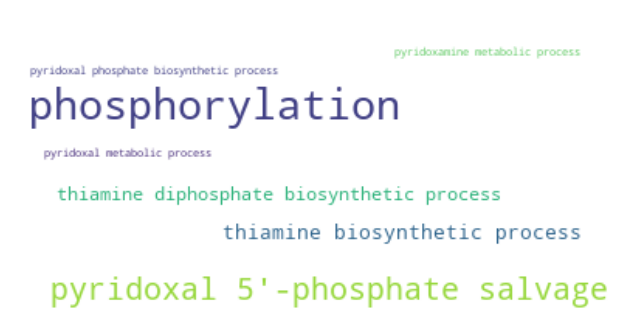

In [73]:
# BIOLOGICAL PROCESS
wc_dict = (mdl_enrichment_df[mdl_enrichment_df['domain']=='bp'].set_index('term_name')['prob_term']*50).astype('int64').to_dict()
wc = WordCloud(background_color='white').generate_from_frequencies(wc_dict)
plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

### Most Enriched Branches

Since nodes at all levels are parsed in previous steps, it is sufficient to get level information for each term.  
Getting information for high level terms is simply a matter by calculating, then filtering by level. No graph traversal is needed.

In [74]:
go_obo = data_dir + "go-basic.obo" 
go = obo_parser.GODag(go_obo) # big file
def get_level(id):
    return go[id].depth
mdl_enrichment_df['level'] = mdl_enrichment_df['term_id'].apply(get_level)
mdl_enrichment_df.head()

data/go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms


,term_id,term_name,domain,count,prob_term,level
0,GO:0005524,ATP binding,mf,149,0.993333,8
1,GO:0031403,lithium ion binding,mf,2,0.013333,7
2,GO:0000287,magnesium ion binding,mf,103,0.686667,6
3,GO:0030955,potassium ion binding,mf,2,0.013333,7
4,GO:0042803,protein homodimerization activity,mf,4,0.026667,4


In [75]:
# Considering heiarchy level 
# most common basal terms
mdl_enrichment_df[mdl_enrichment_df['level']<=3].sort_values(by='count',ascending=False).head(5)

,term_id,term_name,domain,count,prob_term,level
9,GO:0005829,cytosol,cc,38,0.253333,2
11,GO:0005576,extracellular region,cc,2,0.013333,2
12,GO:0005654,nucleoplasm,cc,2,0.013333,2
21,GO:0097159,organic cyclic compound binding,mf,2,0.013333,2
24,GO:0036094,small molecule binding,mf,2,0.013333,2


In [76]:
# most common nodes that are low in the GO heiarchy
mdl_enrichment_df[mdl_enrichment_df['level']>4].sort_values(by='count',ascending=False).head(5)

,term_id,term_name,domain,count,prob_term,level
0,GO:0005524,ATP binding,mf,149,0.993333,8
16,GO:0016310,phosphorylation,bp,149,0.993333,5
5,GO:0008478,pyridoxal kinase activity,mf,117,0.780000,5
17,GO:0009443,pyridoxal 5'-phosphate salvage,bp,112,0.746667,8
2,GO:0000287,magnesium ion binding,mf,103,0.686667,6


In [77]:
mdl_enrichment_df.sort_values(by='count', ascending=False)

,term_id,term_name,domain,count,prob_term,level
0,GO:0005524,ATP binding,mf,149,0.993333,8
16,GO:0016310,phosphorylation,bp,149,0.993333,5
5,GO:0008478,pyridoxal kinase activity,mf,117,0.780000,5
17,GO:0009443,pyridoxal 5'-phosphate salvage,bp,112,0.746667,8
2,GO:0000287,magnesium ion binding,mf,103,0.686667,6
36,GO:0008972,phosphomethylpyrimidine kinase activity,mf,38,0.253333,5
9,GO:0005829,cytosol,cc,38,0.253333,2
39,GO:0009228,thiamine biosynthetic process,bp,38,0.253333,7
8,GO:0008270,zinc ion binding,mf,37,0.246667,7
35,GO:0008902,hydroxymethylpyrimidine kinase activity,mf,36,0.240000,5


In [78]:
tst_dict = {}
for i, r in mdl_info_df.iterrows():
    id_raw = r['Gene Ontology IDs']
    ids = str.split(id_raw, ';')
    for id in ids:
        if id not in tst_dict.keys():
            tst_dict[id] = 1
        else:
            tst_dict[id] += 1
#tst_dict

In [79]:
len(tst_dict)

59

In [80]:
mdl_info_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Pfam,Taxonomic lineage,Taxonomic lineage (Ids),Gene Ontology IDs,Gene Ontology (molecular function),Gene Ontology (GO),Gene Ontology (cellular component),Gene Ontology (biological process),Sequence,PROSITE
4204,O00764,reviewed,PDXK_HUMAN,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK C21orf124 C21orf97 PKH PNK PRED79,Homo sapiens (Human),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0000287; GO:0005524; GO:0005576; GO:0005634...,ATP binding [GO:0005524]; lithium ion binding ...,cytosol [GO:0005829]; extracellular exosome [G...,cytosol [GO:0005829]; extracellular exosome [G...,phosphorylation [GO:0016310]; pyridoxal 5'-pho...,MEEECRVLSIQSHVIRGYVGNRAATFPLQVLGFEIDAVNSVQFSNH...,NaN
5601,O35331,reviewed,PDXK_RAT,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,Pdxk Pkh,Rattus norvegicus (Rat),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009410...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],negative regulation of apoptotic process [GO:0...,MEGECRVLSIQSHVVRGYVGNRAAMFPLQVLGFEVDAVNSVQFSNH...,NaN
6209,O46560,reviewed,PDXK_PIG,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK PKH,Sus scrofa (Pig),322,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009443...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...,MQAGSWVVGGGDSDSRVLSIQSHVVRGYVGNRAATFPLQVLGFEVD...,NaN
6247,O48881,reviewed,TPS1_BRANA,Thiamine biosynthetic bifunctional enzyme BTH1...,BTH1,Brassica napus (Rape),523,PF08543;PF02581;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (...",GO:0004789; GO:0005524; GO:0008902; GO:0008972...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,chloroplast [GO:0009507]; ATP binding [GO:0005...,chloroplast [GO:0009507],phosphorylation [GO:0016310]; thiamine biosynt...,MQSLGGIRSWPATWRTTTASMTTTTTESVRKVAQVLTVAGSDSGAG...,NaN
19833,P39610,reviewed,PDXK_BACSU,Pyridoxine kinase (EC 2.7.1.35) (PN/PL/PM kina...,pdxK ywdB BSU38020 ipa-52r,Bacillus subtilis (strain 168),271,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0005524; GO:0005829; GO:0008478; GO:0008902...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; thiamine biosynt...,MSMHKALTIAGSDSSGGAGIQADLKTFQEKNVYGMTALTVIVAMDP...,NaN


In [81]:
go['GO:0005524']

GOTerm('GO:0005524'):
  id:GO:0005524
  item_id:GO:0005524
  name:ATP binding
  namespace:molecular_function
  _parents: 2 items
    GO:0035639
    GO:0032559
  parents: 2 items
    GO:0032559	level-05	depth-07	adenyl ribonucleotide binding [molecular_function]
    GO:0035639	level-04	depth-05	purine ribonucleoside triphosphate binding [molecular_function]
  children: 0 items
  level:5
  depth:8
  is_obsolete:False
  alt_ids: 0 items

## Motifs
Use ELM and ProSite to find short conserved motifs within your family

### ELM  
The ELM database cataloges a series of linear motifs in the form of regular expressions (regex) corresponding to functional sites in proteins.  
The tsv file of all such expressions was downloaded from the elm website. 
By iterating over every sequence in our family model and every motif in ELM we can detect the presence of a motifs in our sequences.  
The motifs detected are then recorded and aggrogated to see if there are motifs that caracterize our family.  

In [82]:
# downloaded from the ELM website
elm = pd.read_csv(data_dir + 'elm_classes.tsv', sep='\t')

In [83]:
elm.head()

,Accession,ELMIdentifier,FunctionalSiteName,Description,Regex,Probability,#Instances,#Instances_in_PDB
0,ELME000321,CLV_C14_Caspase3-7,Caspase cleavage motif,Caspase-3 and Caspase-7 cleavage site.,[DSTE][^P][^DEWHFYC]D[GSAN],0.003094,41,0
1,ELME000172,CLV_MEL_PAP_1,Melanisation activation site,Prophenoloxidase-activating proteinase (PAP) c...,[ILV]..R[VF][GS].,0.000105,12,0
2,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,N-Arg dibasic convertase (NRD/Nardilysin) clea...,(.RK)|(RR[^KR]),0.007465,2,0
3,ELME000101,CLV_PCSK_FUR_1,PCSK cleavage site,Furin (PACE) cleavage site (R-X-[RK]-R-|-X).,R.[RK]R.,0.000509,13,0
4,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,Yeast kexin 2 cleavage site (K-R-|-X or R-R-|-X).,[KR]R.,0.007973,1,0


In [84]:
mdl_info_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Pfam,Taxonomic lineage,Taxonomic lineage (Ids),Gene Ontology IDs,Gene Ontology (molecular function),Gene Ontology (GO),Gene Ontology (cellular component),Gene Ontology (biological process),Sequence,PROSITE
4204,O00764,reviewed,PDXK_HUMAN,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK C21orf124 C21orf97 PKH PNK PRED79,Homo sapiens (Human),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0000287; GO:0005524; GO:0005576; GO:0005634...,ATP binding [GO:0005524]; lithium ion binding ...,cytosol [GO:0005829]; extracellular exosome [G...,cytosol [GO:0005829]; extracellular exosome [G...,phosphorylation [GO:0016310]; pyridoxal 5'-pho...,MEEECRVLSIQSHVIRGYVGNRAATFPLQVLGFEIDAVNSVQFSNH...,NaN
5601,O35331,reviewed,PDXK_RAT,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,Pdxk Pkh,Rattus norvegicus (Rat),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009410...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],negative regulation of apoptotic process [GO:0...,MEGECRVLSIQSHVVRGYVGNRAAMFPLQVLGFEVDAVNSVQFSNH...,NaN
6209,O46560,reviewed,PDXK_PIG,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK PKH,Sus scrofa (Pig),322,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009443...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...,MQAGSWVVGGGDSDSRVLSIQSHVVRGYVGNRAATFPLQVLGFEVD...,NaN
6247,O48881,reviewed,TPS1_BRANA,Thiamine biosynthetic bifunctional enzyme BTH1...,BTH1,Brassica napus (Rape),523,PF08543;PF02581;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (...",GO:0004789; GO:0005524; GO:0008902; GO:0008972...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,chloroplast [GO:0009507]; ATP binding [GO:0005...,chloroplast [GO:0009507],phosphorylation [GO:0016310]; thiamine biosynt...,MQSLGGIRSWPATWRTTTASMTTTTTESVRKVAQVLTVAGSDSGAG...,NaN
19833,P39610,reviewed,PDXK_BACSU,Pyridoxine kinase (EC 2.7.1.35) (PN/PL/PM kina...,pdxK ywdB BSU38020 ipa-52r,Bacillus subtilis (strain 168),271,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0005524; GO:0005829; GO:0008478; GO:0008902...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; thiamine biosynt...,MSMHKALTIAGSDSSGGAGIQADLKTFQEKNVYGMTALTVIVAMDP...,NaN


In [85]:
elm_hits = []
for i, seq_r in mdl_info_df.iterrows():
    acc = seq_r['Entry']
    seq = seq_r['Sequence']
    for j, motif_r in elm.iterrows():
        #motif = motif_r['']
        exp = motif_r['Regex']
        motif_hits = re.findall(exp, seq)
        if len(motif_hits) > 0:
            elm_hits.append([acc] + list(motif_r[['Accession','ELMIdentifier', 'FunctionalSiteName']]) + [len(motif_hits)])
elm_hits_df = pd.DataFrame(elm_hits, columns=['acc_uni', 'acc_elm', 'ELMIdentifier', 'funcSiteName', 'hits'])
elm_hits_df

,acc_uni,acc_elm,ELMIdentifier,funcSiteName,hits
0,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,3
1,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,2
2,O00764,ELME000100,CLV_PCSK_PC1ET2_1,PCSK cleavage site,1
3,O00764,ELME000146,CLV_PCSK_SKI1_1,PCSK cleavage site,2
4,O00764,ELME000352,DEG_Nend_UBRbox_2,N-degron,1
...,...,...,...,...,...
7014,Q9ZL00,ELME000526,TRG_DiLeu_BaEn_4,Adaptin binding Endosome-Lysosome-Basolateral ...,1
7015,Q9ZL00,ELME000528,TRG_DiLeu_BaLyEn_6,Adaptin binding Endosome-Lysosome-Basolateral ...,1
7016,Q9ZL00,ELME000120,TRG_ENDOCYTIC_2,Y-based sorting signal,1
7017,Q9ZL00,ELME000011,TRG_ER_diLys_1,di Lysine ER retrieving signal,1


In [86]:
elm_mdl_hits_df = pd.merge(
    elm_hits_df.groupby('acc_elm')['hits'].sum().sort_values(ascending=False).to_frame().reset_index(),
    elm_hits_df[['acc_elm', 'ELMIdentifier', 'funcSiteName']].groupby('acc_elm').first().reset_index(), 
    how='left'
)[['acc_elm','ELMIdentifier', 'funcSiteName','hits']]
elm_mdl_hits_df

,acc_elm,ELMIdentifier,funcSiteName,hits
0,ELME000365,LIG_WD40_WDR5_VDV_2,"WDR5 WD40 repeat (blade 5,6)-binding ligand",1167
1,ELME000085,MOD_GlcNHglycan,Glycosaminoglycan attachment site,671
2,ELME000052,LIG_FHA_1,FHA phosphopeptide ligands,603
3,ELME000146,CLV_PCSK_SKI1_1,PCSK cleavage site,530
4,ELME000182,LIG_SH2_STAT5,Phosphotyrosine ligands bound by SH2 domains,482
...,...,...,...,...
202,ELME000397,LIG_LRP6_Inhibitor_1,Extracellular side LRP5 and -6 binding motif,1
203,ELME000490,DOC_CYCLIN_yClb1_LxF_4,Cyclin N-terminal Domain Docking Motifs,1
204,ELME000396,LIG_DCNL_PONY_1,DCNL binding motif,1
205,ELME000493,LIG_NRP_CendR_1,CendR Motif Binding to Neuropilin Receptors,1


Collect all the times a sequence in our family matches an elm pattern

In [87]:
# use re.finditer to get ranges of elm hits
elm_hits = []
for i, seq_r in mdl_info_df.iterrows():
    acc = seq_r['Entry']
    seq = seq_r['Sequence']
    for j, motif_r in elm.iterrows():
        #motif = motif_r['']
        exp = motif_r['Regex']
        motif_hits = re.finditer(exp, seq)
        for hit in motif_hits:
            start = hit.start()
            end = hit.end()
            elm_hits.append([acc] + list(motif_r[['Accession', 'ELMIdentifier', 'FunctionalSiteName']]) + [start, end])
        #if len(motif_hits) > 0:
        #    elm_hits.append([acc] + list(motif_r[['Accession','FunctionalSiteName']]) + [len(motif_hits)])
elm_hits_df = pd.DataFrame(elm_hits, columns=['acc_uni', 'acc_elm', 'ELMIdentifier', 'funcSiteName', 'start', 'end'])
elm_hits_df

,acc_uni,acc_elm,ELMIdentifier,funcSiteName,start,end
0,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,158,161
1,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,206,209
2,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,222,225
3,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,205,208
4,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,296,299
...,...,...,...,...,...,...
13351,Q9ZL00,ELME000526,TRG_DiLeu_BaEn_4,Adaptin binding Endosome-Lysosome-Basolateral ...,118,125
13352,Q9ZL00,ELME000528,TRG_DiLeu_BaLyEn_6,Adaptin binding Endosome-Lysosome-Basolateral ...,125,131
13353,Q9ZL00,ELME000120,TRG_ENDOCYTIC_2,Y-based sorting signal,3,7
13354,Q9ZL00,ELME000011,TRG_ER_diLys_1,di Lysine ER retrieving signal,265,269


Filter the hits by disordered region information from MobiDB-lite

In [88]:
mobi_dict = pd.read_csv(data_dir + 'mobidb_lite_swissprot.csv', names=['acc','ranges']).set_index('acc').to_dict()['ranges']
mobi_df = pd.read_csv(data_dir + 'mobidb_lite_swissprot.csv', names=['acc_uni','ranges'])
mobi_dict

{'P9WEU3': '[[1493,1529]]',
 'P9WEU4': '[[1,84],[118,141]]',
 'P0DTH5': '[[1,38]]',
 'P0DO34': '[[1,24]]',
 'P0DO30': '[[2520,2583],[2597,2621]]',
 'P0DO27': '[[1,26]]',
 'P0DUK1': '[[1,53]]',
 'Q6GZX1': '[[38,60]]',
 'Q6GZX3': '[[261,294]]',
 'Q6GZX0': '[[1,20]]',
 'Q197F8': '[[339,397],[434,458]]',
 'Q197F3': '[[392,435]]',
 'Q197E7': '[[13,34]]',
 'Q6GZW1': '[[95,119]]',
 'Q6GZW0': '[[277,322]]',
 'Q6GZV5': '[[27,61]]',
 'Q197E9': '[[73,169]]',
 'Q6GZV4': '[[42,71]]',
 'Q197D2': '[[285,337]]',
 'Q197D0': '[[98,127]]',
 'Q6GZV6': '[[1,24],[61,91],[104,160],[190,216],[340,400]]',
 'Q197C8': '[[136,279]]',
 'Q6GZU9': '[[942,970]]',
 'Q6GZU4': '[[30,155],[169,327],[376,474]]',
 'Q6GZU1': '[[24,87],[101,153]]',
 'Q6GZT7': '[[77,116]]',
 'Q197C3': '[[141,225]]',
 'Q6GZT6': '[[68,90]]',
 'Q197C0': '[[15,36]]',
 'Q6GZT4': '[[1,22],[41,85]]',
 'Q91G56': '[[1,22]]',
 'Q6GZT0': '[[46,81]]',
 'Q6GZT5': '[[422,442]]',
 'Q6GZS7': '[[1,110]]',
 'Q6GZS6': '[[61,229]]',
 'Q6GZS2': '[[1,24]]',
 'Q197

In [89]:
def cal_overlap(a, b, c, d):
    """
    Calculate the length of the overlap between two ranges (a, b) and (c, d).
    
    Parameters:
    - a, b: Endpoints of the first range, with a <= b.
    - c, d: Endpoints of the second range, with c <= d.
    
    Returns:
    The length of the overlap between the two ranges. Returns 0 if there is no overlap.
    """
    # Find the maximum of the start points and the minimum of the end points
    overlap_start = max(a, c)
    overlap_end = min(b, d)
    
    # Calculate the overlap length
    overlap_length = overlap_end - overlap_start
    
    # If there's no overlap, return 0
    return max(0, overlap_length)


In [90]:
disorder_hits = []
disorder_dict = {}
for i, hit_r in elm_hits_df.iterrows():
    acc_uni = hit_r['acc_uni']
    #print(acc_uni)
    try:
        range_txt = mobi_dict[acc_uni][1:-1]
        disorder_dict[i] = range_txt
        #print(acc_uni, range_txt)
        ranges = re.findall(r'\[([^\]]+)\]', range_txt)
        for r in ranges:
            #print(r)
            pattern_start, pattern_end = str.split(r,',')
            pattern_start, pattern_end = int(pattern_start), int(pattern_end)
            #print(pattern_start, pattern_end)
            pattern_len = pattern_end - pattern_start
            #print(pattern_len)
            #print(str(type(pattern_start)))
            subject_start, subject_end = int(hit_r['start']), int(hit_r['end'])
            overlap =  cal_overlap(pattern_start, pattern_end, subject_start, subject_end)
            #print(overlap)
            #print(1)
            #print(acc_uni)
            #print(pattern_start, pattern_end, hit_r['start'],hit_r['end'])
            
            disorder_hits.append(overlap/pattern_len)
    except:
        1 # protein has no disordered regions in MobiDB (common), don't log


In [91]:
len(disorder_hits)

168

In [92]:
elm_hits_df['disorder_ranges'] = elm_hits_df.index.map(disorder_dict.get)
elm_hits_df

,acc_uni,acc_elm,ELMIdentifier,funcSiteName,start,end,disorder_ranges
0,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,158,161,None
1,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,206,209,None
2,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,222,225,None
3,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,205,208,None
4,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,296,299,None
...,...,...,...,...,...,...,...
13351,Q9ZL00,ELME000526,TRG_DiLeu_BaEn_4,Adaptin binding Endosome-Lysosome-Basolateral ...,118,125,None
13352,Q9ZL00,ELME000528,TRG_DiLeu_BaLyEn_6,Adaptin binding Endosome-Lysosome-Basolateral ...,125,131,None
13353,Q9ZL00,ELME000120,TRG_ENDOCYTIC_2,Y-based sorting signal,3,7,None
13354,Q9ZL00,ELME000011,TRG_ER_diLys_1,di Lysine ER retrieving signal,265,269,None


In [93]:
elm_hits_df.to_csv('elm_hits.csv')

Only one protein in the family has any disordered regions in Mobi-DB lite!

In [94]:
elm_hits_df[elm_hits_df['disorder_ranges'].notna()]

,acc_uni,acc_elm,ELMIdentifier,funcSiteName,start,end,disorder_ranges
3541,Q2QWK9,ELME000321,CLV_C14_Caspase3-7,Caspase cleavage motif,234,239,"[1,40]"
3542,Q2QWK9,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,28,31,"[1,40]"
3543,Q2QWK9,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,38,41,"[1,40]"
3544,Q2QWK9,ELME000101,CLV_PCSK_FUR_1,PCSK cleavage site,36,41,"[1,40]"
3545,Q2QWK9,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,28,31,"[1,40]"
...,...,...,...,...,...,...,...
3704,Q2QWK9,ELME000012,TRG_ER_diArg_1,di Arginine retention/retrieving signal,27,30,"[1,40]"
3705,Q2QWK9,ELME000012,TRG_ER_diArg_1,di Arginine retention/retrieving signal,35,39,"[1,40]"
3706,Q2QWK9,ELME000193,TRG_NES_CRM1_1,NES Nuclear Export Signals,114,127,"[1,40]"
3707,Q2QWK9,ELME000462,TRG_Pf-PMV_PEXEL_1,Apicomplexan export motif,140,145,"[1,40]"


In [95]:
# Generate fasta to be alligned with clustalw, download as FASTA. Can be done at the NCBI website
# save the mdlSequences_aln.fasta to be used for the motif plots
with open(data_dir + 'mdlSequences.fasta','w') as f:
    for i,r in mdl_info_df[['Entry', 'Sequence']].iterrows():
        f.write('>|' + r['Entry'] + '\n')
        f.write(r['Sequence']  + '\n')


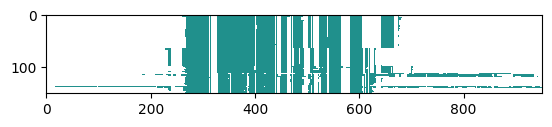

In [96]:
#fasta_file = "PF08543_sprot_seq_aln.fasta" # uses the set of True PFAM sequences (only 2 protein difference)
fasta_file = data_dir + 'mdlSequences_aln.fasta' #refined model
img = []
seq_aln_dict = {}
seq_idx_dict = {}
# Read the FASTA file
for i, seq_record in enumerate(SeqIO.parse(fasta_file, "fasta")):
    #print(f"ID: {seq_record.id}")
    #print(f"Description: {seq_record.description}")
    #print(f"Sequence: {seq_record.seq}\n")
    id = str.split(seq_record.id,'|')[1]
    seq = seq_record.seq
    seq_aln_dict[id] = seq
    seq_idx_dict[id] = i
    row = []
    for aa in seq:
        row.append(0 if aa == '-' else 1)
    img.append(row)
img_base = np.array(img)
cmap = ListedColormap(['w', '#20908C','#E6DE2F'])
plt.imshow(img_base, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)

In [97]:
n_elm_patterns = 100
top_elm_df = elm_hits_df.groupby('acc_elm')['acc_uni'].count().sort_values(ascending=False)
elm_top_acc = top_elm_df.head(n_elm_patterns).index.tolist()
elm_top_acc[0:20]

['ELME000365',
 'ELME000085',
 'ELME000052',
 'ELME000146',
 'ELME000182',
 'ELME000053',
 'ELME000063',
 'ELME000370',
 'ELME000333',
 'ELME000444',
 'ELME000239',
 'ELME000136',
 'ELME000159',
 'ELME000155',
 'ELME000202',
 'ELME000064',
 'ELME000462',
 'ELME000120',
 'ELME000368',
 'ELME000220']

In [98]:
elm_hits_df.head()

,acc_uni,acc_elm,ELMIdentifier,funcSiteName,start,end,disorder_ranges
0,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,158,161,None
1,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,206,209,None
2,O00764,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,222,225,None
3,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,205,208,None
4,O00764,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,296,299,None


In [99]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_elm_heatmaps(elm_list, img_base = img_base, elm_hits_df=elm_hits_df, seq_idx_dict=seq_idx_dict, seq_aln_dict=seq_aln_dict, cmap=cmap, scale_multiplier = 3):
    """
    Plot ELM heatmaps on a grid sized based on the number of elements in elm_list.
    
    Parameters:
    - elm_list: List of elements to plot (replaces elm_top_acc).
    - img_base: Base image for plotting.
    - elm_hits_df: DataFrame containing ELM hits information.
    - seq_idx_dict: Dictionary mapping UniProt accession to sequence index.
    - seq_aln_dict: Dictionary mapping UniProt accession to sequence alignment.
    - cmap: Colormap for plotting.
    """
    # Determine grid size
    num_plots = len(elm_list)
    grid_size = math.ceil(math.sqrt(num_plots))  # Square grid to fit all plots
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * scale_multiplier, grid_size * scale_multiplier))
    # Adjust axs to a 2D array for uniform handling
    axs = np.array(axs).reshape(grid_size, grid_size)
    
    for plot_num, acc_elm in enumerate(elm_list):
        img = img_base.copy()
        cur_elm_df = elm_hits_df[elm_hits_df['acc_elm'] == acc_elm]
        
        # Highlight regions in alignment that correspond to a given pattern
        for _, r in cur_elm_df.iterrows():
            acc_uni = r['acc_uni']
            row_idx = seq_idx_dict[acc_uni]
            seq_idx = 0
            aln_col = 0
            seq = seq_aln_dict[acc_uni]
            while seq_idx < r['end']: 
                if seq[aln_col] != '-':
                    if seq_idx >= r['start']:
                        img[row_idx, aln_col] = 2
                    seq_idx += 1
                aln_col += 1
        
        # Calculate subplot indices
        row_idx = plot_num // grid_size
        col_idx = plot_num % grid_size
        
        # Plot the image
        ax = axs[row_idx, col_idx]
        ax.imshow(img, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
        ax.set_title(r['ELMIdentifier']+'\n'+r['funcSiteName'], fontsize=8)
        ax.set_xlim(200, 700)
        #ax.set_xticks([])
        #ax.set_yticks([])
    
    # Hide any unused subplots
    for i in range(plot_num + 1, grid_size**2):
        axs.flatten()[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming elm_top_acc, img_base, elm_hits_df, seq_idx_dict, seq_aln_dict, and cmap are defined
# plot_elm_heatmaps(elm_top_acc, img_base, elm_hits_df, seq_idx_dict, seq_aln_dict, cmap)


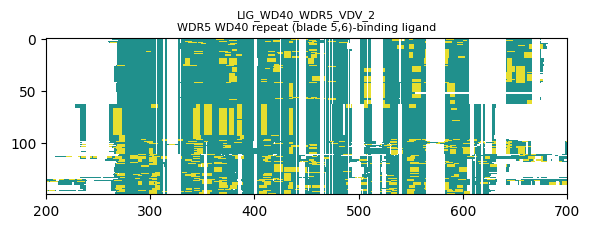

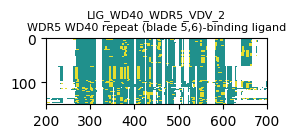

270    0.046779
Name: Probability, dtype: float64

In [100]:
plot_elm_heatmaps(['ELME000365'], scale_multiplier=6) # added a scale mutiplier for better plotting
plot_elm_heatmaps(['ELME000365'])

elm[elm['Accession'] == 'ELME000365']['Probability']

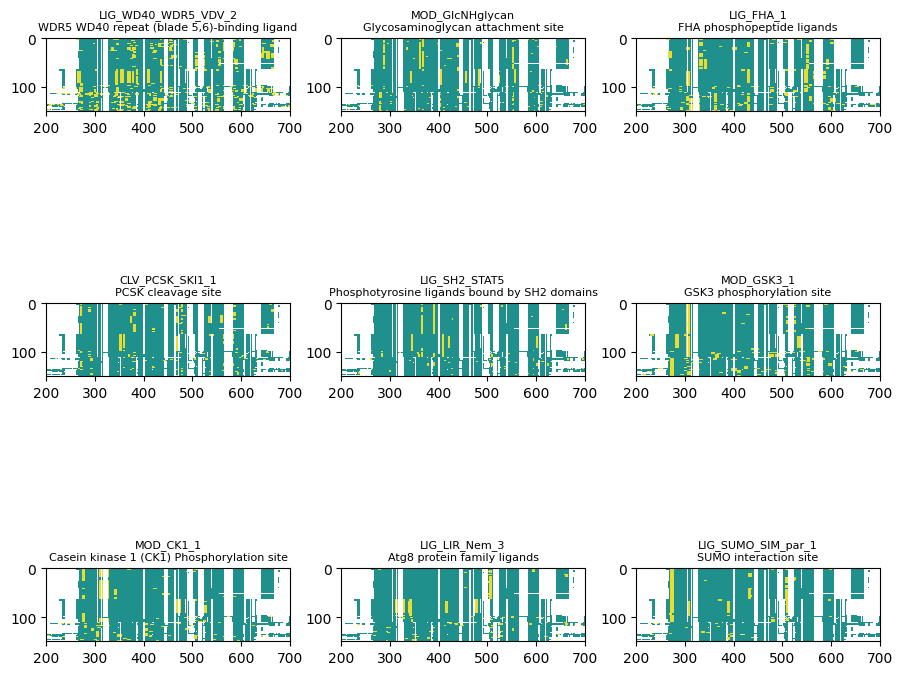

In [101]:
plot_elm_heatmaps(elm_top_acc[:9])

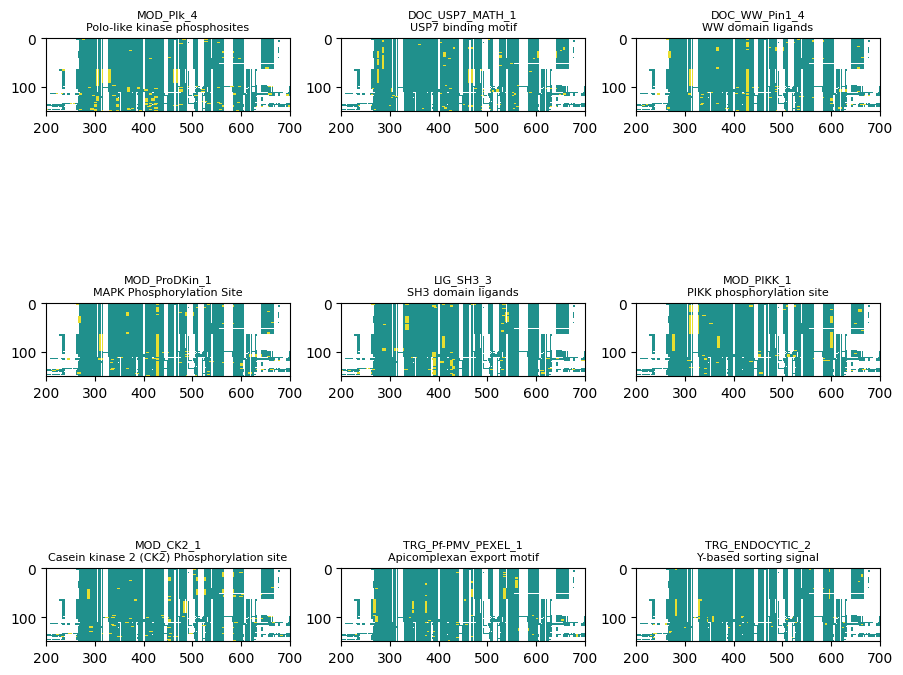

In [102]:
plot_elm_heatmaps(elm_top_acc[9:18])

Mobi-DB light suggests that our family does not contain many disordered regions, as indicated by the very small number of hits.  
We sampled many proteins in the family, and looked them up on the full Mobi-DB website to confirm that the proteins indeed do not have large disordered regions (generally less than 5%).

### ProSite

In [103]:
prosite_patterns = []
with open(data_dir + 'prosite.dat') as f:
    prosite_raw = f.read()
    #for l in f:
    #    if l[0:2] == 'PA':
    #        prosite_patterns.append(l[5:].strip())
prosite_entries = str.split(prosite_raw, '//')

In [104]:
prosite_patterns = []
for i, e in enumerate(prosite_entries):
    ID, DE, AC, PA = None, None, None, None
    for l in str.splitlines(e):
        try:
            #there's absolutely a better way to do this
            feild , val = l[:2], l[5:]#str.split(l,'   ')
            
            if feild == 'ID': # this is dumb
                ID = val
            if feild == 'DE':
                DE = val
            if feild == 'AC':
                AC = val[:-1] # trim trailing ;
            if feild == 'PA':
                PA = val
                prosite_patterns.append([ID, DE, AC, PA])
        except:
            continue
prosite_df = pd.DataFrame(prosite_patterns, columns=['ID', 'DE', 'AC', 'PA'])
prosite_df

,ID,DE,AC,PA
0,ASN_GLYCOSYLATION; PATTERN.,N-glycosylation site.,PS00001,N-{P}-[ST]-{P}.
1,CAMP_PHOSPHO_SITE; PATTERN.,cAMP- and cGMP-dependent protein kinase phosph...,PS00004,[RK](2)-x-[ST].
2,PKC_PHOSPHO_SITE; PATTERN.,Protein kinase C phosphorylation site.,PS00005,[ST]-x-[RK].
3,CK2_PHOSPHO_SITE; PATTERN.,Casein kinase II phosphorylation site.,PS00006,[ST]-x(2)-[DE].
4,TYR_PHOSPHO_SITE_1; PATTERN.,Tyrosine kinase phosphorylation site 1.,PS00007,[RK]-x(2)-[DE]-x(3)-Y.
...,...,...,...,...
1698,SPIDER_CSTX; PATTERN.,Spider toxin CSTX family signature.,PS60029,C-{C}(6)-C-{C}(6)-C-C-{C}(8)-C-{C}-C.
1699,BACTERIOCIN_IIA; PATTERN.,Bacteriocin class IIa family signature.,PS60030,Y-G-N-G-[VL]-x-C-x(4)-C.
1700,GARP2; PATTERN.,Glutamic acid-rich protein 2 (GARP2) signature.,PS60031,C-D-V-Q-T-R-[VAE]-[MVT]-[GA]-A-G-[GS]-L.
1701,GH9_1; PATTERN.,Glycosyl hydrolases family 9 (GH9) active site...,PS60032,[LVS]-x-[GK]-G-[WFYLM]-[YHF]-D-[ACGS]-G-[DSN]-...


In order to process sequence information given ProSite patterns we will use this precompiled file that coorelates ProSite assentions with the patterns corresponding regular expression.  
https://github.com/stevin-wilson/PrositePatternsToPythonRegex/blob/master/prosite_preprocessed.txt

In [105]:
prosite_REs = [] 
with open(data_dir + 'prosite_preprocessed.txt') as f:
    for l in f:
        #try:
        feilds = l.split('\t')
        acc_prosite = feilds[0]
        re_pattern = feilds[1].rstrip()
        # Two patterns return more than one RE. They aren't relevant, so they are ignored
        # PS00267	F[IVFY]G[LM]M[G]	&	F[IVFY]G[LM]M$
        # PS00539	F[GSTV]PRL[G]	&	F[GSTV]PRL$
        prosite_REs.append([acc_prosite, re_pattern])
prosite_REs_df = pd.DataFrame(prosite_REs, columns=['acc_prosite', 're'])
prosite_REs_df

,acc_prosite,re
0,PS00001,N[ACDEFGHIKLMNQRSTVWY][ST][ACDEFGHIKLMNQRSTVWY]
1,PS00004,[RK]{2}.[ST]
2,PS00005,[ST].[RK]
3,PS00006,[ST].{2}[DE]
4,PS00007,[RK].{2}[DE].{3}Y
...,...,...
1306,PS60028,C.{6}C.{5}CC.{3}C.{9}RC
1307,PS60029,C[ADEFGHIKLMNPQRSTVWY]{6}C[ADEFGHIKLMNPQRSTVWY...
1308,PS60030,YGNG[VL].C.{4}C
1309,PS60031,CDVQTR[VAE][MVT][GA]AG[GS]L


In [106]:
prosite_df = pd.merge(prosite_df, prosite_REs_df, how='inner',left_on='AC',right_on='acc_prosite')
prosite_desc_dict = prosite_df[['AC','DE']].set_index('AC').to_dict()['DE']
prosite_df

,ID,DE,AC,PA,acc_prosite,re
0,ASN_GLYCOSYLATION; PATTERN.,N-glycosylation site.,PS00001,N-{P}-[ST]-{P}.,PS00001,N[ACDEFGHIKLMNQRSTVWY][ST][ACDEFGHIKLMNQRSTVWY]
1,CAMP_PHOSPHO_SITE; PATTERN.,cAMP- and cGMP-dependent protein kinase phosph...,PS00004,[RK](2)-x-[ST].,PS00004,[RK]{2}.[ST]
2,PKC_PHOSPHO_SITE; PATTERN.,Protein kinase C phosphorylation site.,PS00005,[ST]-x-[RK].,PS00005,[ST].[RK]
3,CK2_PHOSPHO_SITE; PATTERN.,Casein kinase II phosphorylation site.,PS00006,[ST]-x(2)-[DE].,PS00006,[ST].{2}[DE]
4,TYR_PHOSPHO_SITE_1; PATTERN.,Tyrosine kinase phosphorylation site 1.,PS00007,[RK]-x(2)-[DE]-x(3)-Y.,PS00007,[RK].{2}[DE].{3}Y
...,...,...,...,...,...,...
1698,SPIDER_CSTX; PATTERN.,Spider toxin CSTX family signature.,PS60029,C-{C}(6)-C-{C}(6)-C-C-{C}(8)-C-{C}-C.,PS60029,C[ADEFGHIKLMNPQRSTVWY]{6}C[ADEFGHIKLMNPQRSTVWY...
1699,BACTERIOCIN_IIA; PATTERN.,Bacteriocin class IIa family signature.,PS60030,Y-G-N-G-[VL]-x-C-x(4)-C.,PS60030,YGNG[VL].C.{4}C
1700,GARP2; PATTERN.,Glutamic acid-rich protein 2 (GARP2) signature.,PS60031,C-D-V-Q-T-R-[VAE]-[MVT]-[GA]-A-G-[GS]-L.,PS60031,CDVQTR[VAE][MVT][GA]AG[GS]L
1701,GH9_1; PATTERN.,Glycosyl hydrolases family 9 (GH9) active site...,PS60032,[LVS]-x-[GK]-G-[WFYLM]-[YHF]-D-[ACGS]-G-[DSN]-...,PS60032,[LVS].[GK]G[WFYLM][YHF]D[ACGS]G[DSN]X{2}[KMR][...


In [107]:
# use re.finditer to get ranges of prosite hits
prosite_hits = []
for i, seq_r in mdl_info_df.iterrows():
    acc_uni = seq_r['Entry']
    seq = seq_r['Sequence']
    for j, motif_r in prosite_df.iterrows():
        acc_pro = motif_r['acc_prosite']
        exp = motif_r['re']
        #print(exp)
        motif_hits = re.finditer(exp, seq)
        for hit in motif_hits:
            #print('Hit!')
            start = hit.start()
            end = hit.end()
            prosite_hits.append([acc_uni, acc_pro, start, end])
        #if len(motif_hits) > 0:
        #    elm_hits.append([acc] + list(motif_r[['Accession','FunctionalSiteName']]) + [len(motif_hits)])
#elm_hits_df = pd.DataFrame(elm_hits, columns=['acc_uni', 'acc_elm', 'funcSiteName', 'start', 'end'])
#elm_hits_df
prosite_hits_df = pd.DataFrame(prosite_hits, columns=['acc_uni', 'acc_pro', 'start', 'end'])

In [108]:
prosite_hits_df.head()

,acc_uni,acc_pro,start,end
0,O00764,PS00001,44,48
1,O00764,PS00005,157,160
2,O00764,PS00005,203,206
3,O00764,PS00005,244,247
4,O00764,PS00005,295,298


In [109]:
prosite_hits_df.groupby(by=['acc_uni','acc_pro']).count().head()

start  end
acc_uni acc_pro            
A1ADT5  PS00005      2    2
        PS00006      2    2
        PS00007      1    1
        PS00008      4    4
A3N2D3  PS00001      2    2

In [110]:
prosite_hits_df['acc_pro'].unique()

array(['PS00001', 'PS00005', 'PS00006', 'PS00008', 'PS00009', 'PS00007',
       'PS60007', 'PS00004', 'PS00342', 'PS00029', 'PS00017', 'PS00626',
       'PS00016'], dtype=object)

There are 13 prosite patterns detected over the entire family. However, only 4 occur in a significant fraction of all sequences in the family.

In [111]:
family_prosite_acc = list(prosite_hits_df['acc_pro'].unique())[:4]
family_prosite_acc

['PS00001', 'PS00005', 'PS00006', 'PS00008']

PS00001
159


PS00005
334
PS00006
429
PS00008
632


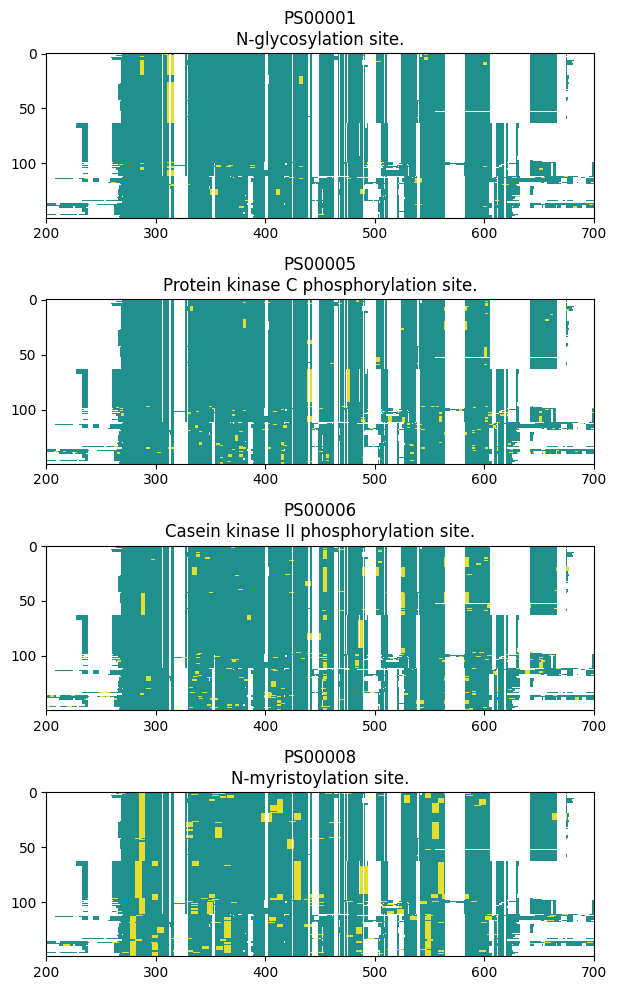

In [112]:
n_patterns = len(family_prosite_acc)
fig, axs = plt.subplots(n_patterns, 1, figsize=(10, 10))
for plot_num, acc_prosite in enumerate(family_prosite_acc):
    img = img_base.copy()
    print(acc_prosite)
    cur_pro_df = prosite_hits_df[prosite_hits_df['acc_pro'] == acc_prosite]
    print(len(cur_pro_df))
    
    # hilight regions in alignment that correspond to a given pattern
    for hit_num,r in cur_pro_df.iterrows():
        acc_uni = r['acc_uni']
        row_idx = seq_idx_dict[acc_uni]
        seq_idx = 0 # index corresponding to contig. seq from uniprot
        aln_col = 0 # current col number in the MSA
        seq = seq_aln_dict[acc_uni]
        while seq_idx < r['end']: 
            if seq[aln_col] != '-':
                # not an empty aa, inc seq_idx
                if seq_idx >= r['start']:
                    img[row_idx, aln_col] = 2
                seq_idx += 1
            aln_col += 1 # always inc index in MSA
            
    axs[plot_num].imshow(img, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    axs[plot_num].set_title(acc_prosite + "\n" + prosite_desc_dict[acc_prosite])
    axs[plot_num].set_xlim(200,700)
plt.tight_layout()